# Decision tree for 0MA+enumeration queries
## SparkSQL, basic features+POS features

In [1]:
!pip install numpy==1.26.0
!pip install scikit-learn==1.5.0
!pip install statsmodels==0.14.2
!pip install matplotlib==3.9.0
!pip install seaborn==0.13.2
#!pip install torch==1.13.1
#!pip install tqdm==4.66.4
#!pip install dhg==0.9.4

In [351]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.tree import plot_tree
from sklearn.tree import export_text

In [352]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'DejaVu Serif'
plt.rcParams['figure.dpi'] = 600

### Import the data

In [353]:
file_path = 'results/features_times_SPA_full_enum_infos.csv'
df1 = pd.read_csv(file_path)
df1_features = pd.read_csv('results/features_times_POS_extra_full_enum_infos.csv')
df1_features = df1_features[['query', 'total cost', 'min(table rows)', 'max(table rows)', 'mean(table rows)', 'q25(table rows)', 'median(table rows)', 'q75(table rows)', 'min(join rows)', 'max(join rows)', 'mean(join rows)', 'q25(join rows)', 'median(join rows)', 'q75(join rows)']]
df1 = pd.merge(df1, df1_features, on = 'query', how='inner')
df1['0ma'] = 0
df1

bench                    query orig/rewr(med)            orig(med)  \
0     STATS            001-014-full1           orig  0.23393607139587402   
1     STATS            001-014-full2           orig  0.22921180725097656   
2     STATS            001-014-full3           orig  0.22890520095825195   
3     STATS      001-014-augF1-full1           orig  0.27040696144104004   
4     STATS      001-014-augF1-full2           orig   0.2345128059387207   
...     ...                      ...            ...                  ...   
1736  HETIO  16-02-SpDtCuGrGdA-full2              -                   TO   
1737  HETIO  16-02-SpDtCuGrGdA-full3              -                   TO   
1738  HETIO  16-03-SpDtCuGrGeA-full1              -                   TO   
1739  HETIO  16-03-SpDtCuGrGeA-full2              -                   TO   
1740  HETIO  16-03-SpDtCuGrGeA-full3              -                   TO   

               rewr(med)           stage0(med)           stage1(med)  \
0     0.5746369361877441  0.031246185302734375  0.020569562911987305   
1     0.5519716739654541  0.029332876205444336   0.02038741111755371   
2     0.5264458656311035  0.030534029006958008  0.020862102508544922   
3     0.7876770496368408   0.04864144325256348  0.036579132080078125   
4     0.6265854835510254   0.03719043731689453  0.028997421264648438   
...                  ...                   ...                   ...   
1736                  TO                     -                     -   
1737                  TO                     -                     -   
1738                  TO                     -                     -   
1739                  TO                     -                     -   
1740                  TO                     -                     -   

               stage2(med)          stage3(med)  #relations  ...  \
0     0.029339075088500977   0.4817984104156494           3  ...   
1     0.028491973876953125  0.47310543060302734           3  ...   
2     0.027678728103637695   0.4458963871002197           3  ...   
3      0.05184578895568848   0.6506106853485107           3  ...   
4      0.03893017768859863   0.5011601448059082           3  ...   
...                    ...                  ...         ...  ...   
1736                     -                    -          11  ...   
1737                     -                    -          11  ...   
1738                     -                    -          11  ...   
1739                     -                    -          11  ...   
1740                     -                    -          11  ...   

      q25(table rows)  median(table rows)  q75(table rows)  min(join rows)  \
0               493.0               985.0          84975.5            84.0   
1               493.0               985.0          84975.5            84.0   
2               493.0               985.0          84975.5            84.0   
3               399.5               798.0          84882.0            68.0   
4               399.5               798.0          84882.0            68.0   
...               ...                 ...              ...             ...   
1736            974.0              6714.0         134807.5           446.0   
1737            974.0              6714.0         134807.5           446.0   
1738            974.0              6714.0         134807.5           446.0   
1739            974.0              6714.0         134807.5           446.0   
1740            974.0              6714.0         134807.5           446.0   

      max(join rows)  mean(join rows)  q25(join rows)  median(join rows)  \
0              46335          23209.5        11646.75            23209.5   
1              46335          23209.5        11646.75            23209.5   
2              46335          23209.5        11646.75            23209.5   
3              37533          18800.5         9434.25            18800.5   
4              37533          18800.5         9434.25            18800.5   
...              .

In [354]:
file_path = 'results/features_times_SPA_infos.csv'
df2 = pd.read_csv(file_path)
df2_features = pd.read_csv('results/features_times_POS_extra_infos.csv')
df2_features = df2_features[['query', 'total cost', 'min(table rows)', 'max(table rows)', 'mean(table rows)', 'q25(table rows)', 'median(table rows)', 'q75(table rows)', 'min(join rows)', 'max(join rows)', 'mean(join rows)', 'q25(join rows)', 'median(join rows)', 'q75(join rows)']]

df2 = pd.merge(df2, df2_features, on = 'query', how='inner')

df2['0ma'] = 1
df2

bench                    query orig/rewr(med)            orig(med)  \
0     STATS                  001-014           orig   0.2722134590148926   
1     STATS            001-014-augA1           orig  0.39922380447387695   
2     STATS            001-014-augA2           orig   0.3291614055633545   
3     STATS            001-014-augF1           orig  0.30810022354125977   
4     STATS      001-014-augF1-augA1           orig   0.3506002426147461   
...     ...                      ...            ...                  ...   
2931  HETIO   16-03-SpDtCuGrGe-augA6           rewr                   TO   
2932  HETIO   16-03-SpDtCuGrGe-augA7           rewr                   TO   
2933  HETIO   16-03-SpDtCuGrGe-augA8           rewr                   TO   
2934  HETIO   16-03-SpDtCuGrGe-augA9           rewr                   TO   
2935  HETIO  16-03-SpDtCuGrGe-augA10           rewr                   TO   

                rewr(med)           stage0(med)          stage1(med)  \
0      0.4138002395629883   0.04046154022216797   0.3707399368286133   
1       0.520209550857544   0.06049633026123047   0.4597132205963135   
2      0.4853997230529785   0.05938601493835449   0.4222888946533203   
3     0.44165873527526855   0.04836320877075195   0.3932955265045166   
4      0.4178028106689453  0.051546573638916016  0.36621952056884766   
...                   ...                   ...                  ...   
2931    1.882624864578247   0.07332086563110352   1.8206613063812256   
2932   2.0100278854370117  0.062030792236328125    1.956383228302002   
2933   1.8301286697387695   0.06782746315002441   1.7610692977905273   
2934   1.5870471000671387  0.061711788177490234   1.5193724632263184   
2935   1.4906394481658936   0.06400942802429199   1.4227962493896484   

      #relations  #conditions  #filters  ...  q25(table rows)  \
0              3            7         5  ...            493.0   
1              3            7         5  ...            493.0   
2              3            7         5  ...            493.0   
3              3            7         5  ...            399.5   
4              3            7         5  ...            399.5   
...          ...          ...       ...  ...              ...   
2931          11           10         0  ...            974.0   
2932          11           10         0  ...            974.0   
2933          11           10         0  ...            974.0   
2934          11           10         0  ...            974.0   
2935          11           10         0  ...            974.0   

      median(table rows)  q75(table rows)  min(join rows)  max(join rows)  \
0                  985.0          50188.5              84           27256   
1                  985.0          50188.5              84           27256   
2                  985.0          50188.5              84           27256   
3                  798.0          50095.0              68           22078   
4                  798.0          50095.0              68           22078   
...                  ...              ...             ...             ...   
2931              6714.0          83610.5             446        15495028   
2932              6714.0          83610.5             446        15495028   
2933              6714.0          83610.5             446        15495028   
2934              6714.0          83610.5             446        15495028   
2935              6714.0          83610.5             446        15495028   

      mean(join rows)  q25(join rows)  median(join rows)  q75(join rows)  0ma  
0             13670.0          6877.0            13670.0        20463.00    1  
1             13670.0          6877.0            13670.0        20463.00    1  
2             13670.0          6877.0            13670.0        20463.00    1  
3             11073.0          5570.5            11073.0        16575.50    1  
4             11073.0          5570.5            11073.0        16575.50    1  
...               ...             ...     

In [355]:
cols = ['bench', 'query', 'orig/rewr(med)', 'orig(med)', 'rewr(med)',
        '0ma',
       '#joins', 'total cost', 'min(table rows)', 'max(table rows)',
       'mean(table rows)', 'q25(table rows)', 'median(table rows)',
       'q75(table rows)', 'min(join rows)', 'max(join rows)',
       'mean(join rows)', 'q25(join rows)', 'median(join rows)',
       'q75(join rows)', 'depth', 'min(container counts)',
       'max(container counts)', 'mean(container counts)',
       'q25(container counts)', 'median(container counts)',
       'q75(container counts)', 'min(branching factors)',
       'max(branching factors)', 'mean(branching factors)',
       'median(branching factors)', 'q25(branching factors)',
       'q75(branching factors)']

In [356]:
df1 = df1[cols]
df2 = df2[cols]
df = pd.concat([df1, df2]).reset_index(drop=True)
df.head()

bench                query orig/rewr(med)            orig(med)  \
0  STATS        001-014-full1           orig  0.23393607139587402   
1  STATS        001-014-full2           orig  0.22921180725097656   
2  STATS        001-014-full3           orig  0.22890520095825195   
3  STATS  001-014-augF1-full1           orig  0.27040696144104004   
4  STATS  001-014-augF1-full2           orig   0.2345128059387207   

            rewr(med)  0ma  #joins  total cost  min(table rows)  \
0  0.5746369361877441    0       2    11475.41                1   
1  0.5519716739654541    0       2    11475.41                1   
2  0.5264458656311035    0       2    11475.41                1   
3  0.7876770496368408    0       2    11412.99                1   
4  0.6265854835510254    0       2    11412.99                1   

   max(table rows)  ...  mean(container counts)  q25(container counts)  \
0           168966  ...                1.133333                    1.0   
1           168966  ...                1.133333                    1.0   
2           168966  ...                1.133333                    1.0   
3           168966  ...                1.133333                    1.0   
4           168966  ...                1.133333                    1.0   

   median(container counts)  q75(container counts)  min(branching factors)  \
0                       1.0                    1.0                       2   
1                       1.0                    1.0                       2   
2                       1.0                    1.0                       2   
3                       1.0                    1.0                       2   
4                       1.0                    1.0                       2   

  max(branching factors)  mean(branching factors)  median(branching factors)  \
0                      2                      2.0                        2.0   
1                      2                      2.0                        2.0   
2                      2                      2.0                        2.0   
3                      2                      2.0                        2.0   
4                      2                      2.0                        2.0   

   q25(branching factors)  q75(branching factors)  
0                     2.0                     2.0  
1                     2.0                     2.0  
2                     2.0                     2.0  
3                     2.0                     2.0  
4                     2.0                     2.0  

[5 rows x 33 columns]

In [357]:
df.shape

(4677, 33)

In [358]:
df.dtypes

bench                         object
query                         object
orig/rewr(med)                object
orig(med)                     object
rewr(med)                     object
0ma                            int64
#joins                         int64
total cost                   float64
min(table rows)                int64
max(table rows)                int64
mean(table rows)             float64
q25(table rows)              float64
median(table rows)           float64
q75(table rows)              float64
min(join rows)               float64
max(join rows)                object
mean(join rows)              float64
q25(join rows)               float64
median(join rows)            float64
q75(join rows)               float64
depth                          int64
min(container counts)          int64
max(container counts)          int64
mean(container counts)       float64
q25(container counts)        float64
median(container counts)     float64
q75(container counts)        float64
m

In [359]:
df["max(join rows)"] = df["max(join rows)"].astype(float)

In [360]:
100* df[(df["orig/rewr(med)"] == "-") & (df["0ma"] == 0)].shape[0] / 10

1320.0

In [361]:
100* df[(df["orig/rewr(med)"] == "-") & (df["0ma"] == 1)].shape[0] / 10

20.0

#### Delete those examples, where both methods gave a timeout

In [362]:
df[df["orig/rewr(med)"] == "-"].shape

(134, 33)

Some queries did not finish the evaluation within our timeout (100 sec). Therefore, we cannot conclude which variante is the better one and we delete those samples.

In cases where only one of the versions is giving a timeout, we set it the runtime to 100 to be able to work with them.

In [363]:
df = df[df["orig/rewr(med)"] != "-"]
df.shape

(4543, 33)

In [364]:
df[df["orig(med)"] == "TO"].shape

(461, 33)

In [365]:
df['orig(med)'] = df['orig(med)'].replace("TO", 100)

In [366]:
df[df["rewr(med)"] == "TO"].shape

(5, 33)

In [367]:
df['rewr(med)'] = df['rewr(med)'].replace("TO", 100)

In [368]:
df["orig(med)"] = df["orig(med)"].astype(float)

In [369]:
df["rewr(med)"] = df["rewr(med)"].astype(float)

In [370]:
df.loc[df['0ma'] == 1]['orig(med)'].sum()

54796.48432087898

In [371]:
df.loc[df['0ma'] == 0]['orig(med)'].sum()

7551.354425549507

#### Get the feature matrix

Get the features matrix X and the response variables y1 and y1, where once the rewritting time and the evaluation time are taken into consideration and once only the evaluation time. Additionally the response variables have to have numbers in it and we assign 1 = rewr and 0 = orig.

In [372]:
X = df.iloc[:, 5:]
X.head()

0ma  #joins  total cost  min(table rows)  max(table rows)  \
0    0       2    11475.41                1           168966   
1    0       2    11475.41                1           168966   
2    0       2    11475.41                1           168966   
3    0       2    11412.99                1           168966   
4    0       2    11412.99                1           168966   

   mean(table rows)  q25(table rows)  median(table rows)  q75(table rows)  \
0      56650.666667            493.0               985.0          84975.5   
1      56650.666667            493.0               985.0          84975.5   
2      56650.666667            493.0               985.0          84975.5   
3      56588.333333            399.5               798.0          84882.0   
4      56588.333333            399.5               798.0          84882.0   

   min(join rows)  ...  mean(container counts)  q25(container counts)  \
0            84.0  ...                1.133333                    1.0   
1            84.0  ...                1.133333                    1.0   
2            84.0  ...                1.133333                    1.0   
3            68.0  ...                1.133333                    1.0   
4            68.0  ...                1.133333                    1.0   

   median(container counts)  q75(container counts)  min(branching factors)  \
0                       1.0                    1.0                       2   
1                       1.0                    1.0                       2   
2                       1.0                    1.0                       2   
3                       1.0                    1.0                       2   
4                       1.0                    1.0                       2   

   max(branching factors)  mean(branching factors)  median(branching factors)  \
0                       2                      2.0                        2.0   
1                       2                      2.0                        2.0   
2                       2                      2.0                        2.0   
3                       2                      2.0                        2.0   
4                       2                      2.0                        2.0   

   q25(branching factors)  q75(branching factors)  
0                     2.0                     2.0  
1                     2.0                     2.0  
2                     2.0                     2.0  
3                     2.0                     2.0  
4                     2.0                     2.0  

[5 rows x 28 columns]

#### Log-transformations

This basic features do not need log transformations.

In [373]:
min_values = X.min()
max_values = X.max()
diff = max_values-min_values

pd.DataFrame({'Min': min_values, 'Max': max_values, 'Diff': diff})

Min           Max          Diff
0ma                          0.000000  1.000000e+00  1.000000e+00
#joins                       1.000000  1.200000e+01  1.100000e+01
total cost                 197.890000  1.573759e+23  1.573759e+23
min(table rows)              1.000000  1.651913e+07  1.651913e+07
max(table rows)             19.000000  2.851121e+07  2.851119e+07
mean(table rows)             4.600000  2.666326e+07  2.666326e+07
q25(table rows)              1.000000  2.851121e+07  2.851121e+07
median(table rows)           1.000000  2.851121e+07  2.851121e+07
q75(table rows)              1.000000  2.851121e+07  2.851121e+07
min(join rows)               1.000000  4.802314e+10  4.802314e+10
max(join rows)               2.000000  8.992907e+24  8.992907e+24
mean(join rows)              1.200000  1.124113e+24  1.124113e+24
q25(join rows)               1.000000  8.913309e+10  8.913309e+10
median(join rows)            1.000000  4.229421e+11  4.229421e+11
q75(join rows)               1.000000  6.139280e+18  6.139280e+18
depth                        1.000000  7.000000e+00  6.000000e+00
min(container counts)        1.000000  1.000000e+00  0.000000e+00
max(container counts)        2.000000  5.000000e+00  3.000000e+00
mean(container counts)       1.047619  1.600000e+00  5.523810e-01
q25(container counts)        1.000000  1.000000e+00  0.000000e+00
median(container counts)     1.000000  1.000000e+00  0.000000e+00
q75(container counts)        1.000000  1.500000e+00  5.000000e-01
min(branching factors)       1.000000  6.000000e+00  5.000000e+00
max(branching factors)       1.000000  6.000000e+00  5.000000e+00
mean(branching factors)      1.000000  6.000000e+00  5.000000e+00
median(branching factors)    1.000000  6.000000e+00  5.000000e+00
q25(branching factors)       1.000000  6.000000e+00  5.000000e+00
q75(branching factors)       1.000000  6.000000e+00  5.000000e+00

In [374]:
X.hist(layout=(11, 3), figsize=(20, 25))
plt.show()

#### Classification response

Get the column(s) where we have "orig" or "rewr", depending on which method was faster. We now want to encode this as 0 (evaluating the original query faster) and 1 (evaluating the rewritten query faster).

In [375]:
mapping = {'orig': 0, 'rewr': 1}
y1 = df['orig/rewr(med)'].map(mapping)
#y1.head()

The number of appearances of original and rewritten is very balanced.

In [376]:
y1.value_counts()

orig/rewr(med)
0    3003
1    1540
Name: count, dtype: int64

In [377]:
count = y1.value_counts().tolist()[::-1] + ["-"]
count = pd.Series(count)
count.index = ["rewr", "orig", "equal"]
count

rewr     1540
orig     3003
equal       -
dtype: object

In [378]:
df["orig/rewr(med)"].value_counts()

orig/rewr(med)
orig    3003
rewr    1540
Name: count, dtype: int64

#### Train-validation-test split

We split the dataset such that each benchmark dataset is represented in the train and in the test set (stratification). We do a 80% train, 10% validation and 10% test split.

In [379]:
X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2, stratify=df["bench"], random_state=20)
X_val, X_test, y1_val, y1_test = train_test_split(X_test, y1_test, test_size=0.5, stratify=df.loc[X_test.index]["bench"], random_state=20)

### Facts about the test set and runtime differences

In [380]:
y1_test.value_counts()

orig/rewr(med)
0    302
1    153
Name: count, dtype: int64

In [381]:
#df["diff rewr-orig"] = df["rewr(med)"] - df["orig(med)"]
df["diff rewr-orig"] = np.where(
    df["rewr(med)"] == 100, 100,
    np.where(
        df["orig(med)"] == 100, -100, 
        df["rewr(med)"] - df["orig(med)"] 
    )
)

In [382]:
diff_rewr = df.loc[df["diff rewr-orig"] < 0]
diff_orig = df.loc[df["diff rewr-orig"] >= 0]

In [383]:
bins = [0, 0.01, 0.1, 1, 10, 99.99, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']

diff_rewr["cut"] = pd.cut(abs(diff_rewr["diff rewr-orig"]), bins=bins, labels=labels)
diff_orig["cut"] = pd.cut(abs(diff_orig["diff rewr-orig"]), bins=bins, labels=labels)

table_rewr = diff_rewr.groupby('cut').size().reset_index(name = "rewr")
table_orig = diff_orig.groupby('cut').size().reset_index(name = "orig")

table = pd.merge(table_rewr, table_orig, on='cut', how='outer')
table = table.set_index('cut').T
#table.index = ['FP', 'FN']
table

/tmp/ipykernel_39050/1750407932.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_rewr["cut"] = pd.cut(abs(diff_rewr["diff rewr-orig"]), bins=bins, labels=labels)
/tmp/ipykernel_39050/1750407932.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  diff_orig["cut"] = pd.cut(abs(diff_orig["diff rewr-orig"]), bins=bins, labels=labels)
/tmp/ipykernel_39050/1750407932.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=Fa

cut   0.01  0.1     1   10  100   TO
rewr    34  181   336  322  190  477
orig    43  628  1950  301   76    5

In [384]:
diff_rewr = df.loc[y1_test[y1_test == 1].index]
diff_orig = df.loc[y1_test[y1_test == 0].index]

In [385]:
bins = [0, 0.01, 0.1, 1, 10, 99.99, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']

diff_rewr["cut"] = pd.cut(abs(diff_rewr["diff rewr-orig"]), bins=bins, labels=labels)
diff_orig["cut"] = pd.cut(abs(diff_orig["diff rewr-orig"]), bins=bins, labels=labels)

table_rewr = diff_rewr.groupby('cut').size().reset_index(name = "rewr")
table_orig = diff_orig.groupby('cut').size().reset_index(name = "orig")

table = pd.merge(table_rewr, table_orig, on='cut', how='outer')
table = table.set_index('cut').T
#table.index = ['FP', 'FN']
table

/tmp/ipykernel_39050/1750407932.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  table_rewr = diff_rewr.groupby('cut').size().reset_index(name = "rewr")
/tmp/ipykernel_39050/1750407932.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  table_orig = diff_orig.groupby('cut').size().reset_index(name = "orig")


cut   0.01  0.1    1  10  100  TO
rewr     2   19   41  28   24  39
orig     2   62  197  33    7   1

### Train a decision tree and observe the results on the test set

In [386]:
clf = DecisionTreeClassifier(random_state = 20)
clf.fit(X_train, y1_train)
y1_pred_dec_tree = clf.predict(X_test)

In [387]:
y1_train

2640    0
843     0
3810    1
3700    1
4023    1
       ..
3500    1
4562    1
3409    0
3421    1
2700    1
Name: orig/rewr(med), Length: 3634, dtype: int64

In [388]:
accuracy = accuracy_score(y1_test, y1_pred_dec_tree)
print(accuracy)
precision = precision_score(y1_test, y1_pred_dec_tree)
print(precision)
recall = recall_score(y1_test, y1_pred_dec_tree)
print(recall)
conf_matrix = confusion_matrix(y1_test, y1_pred_dec_tree)
conf_matrix

0.9340659340659341
0.9300699300699301
0.869281045751634


array([[292,  10],
       [ 20, 133]])

In [389]:
y1_test[0:20]

121     0
2542    1
28      0
1942    0
3726    1
1461    0
495     0
8       0
182     0
2460    0
3236    1
2874    0
4135    1
2986    1
3320    1
2103    0
3653    1
2228    0
2741    0
3784    1
Name: orig/rewr(med), dtype: int64

In [390]:
y1_pred_probabilities[:,1]

array([0.        , 1.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 1.        , 1.        , 1.        ,
       0.        , 1.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.5       ,
       1.        , 1.        , 0.        , 0.        , 1.        ,
       1.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 1.        , 1.        ,
       1.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.5       ,
       0.        , 0.        , 0.        , 1.        , 1.        ,
       0.        , 0.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 1.        , 1.     

### ROC Curve

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_plot/roc_curve.py:171: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  self.ax_.legend(loc="lower right")


0.9277799419988745

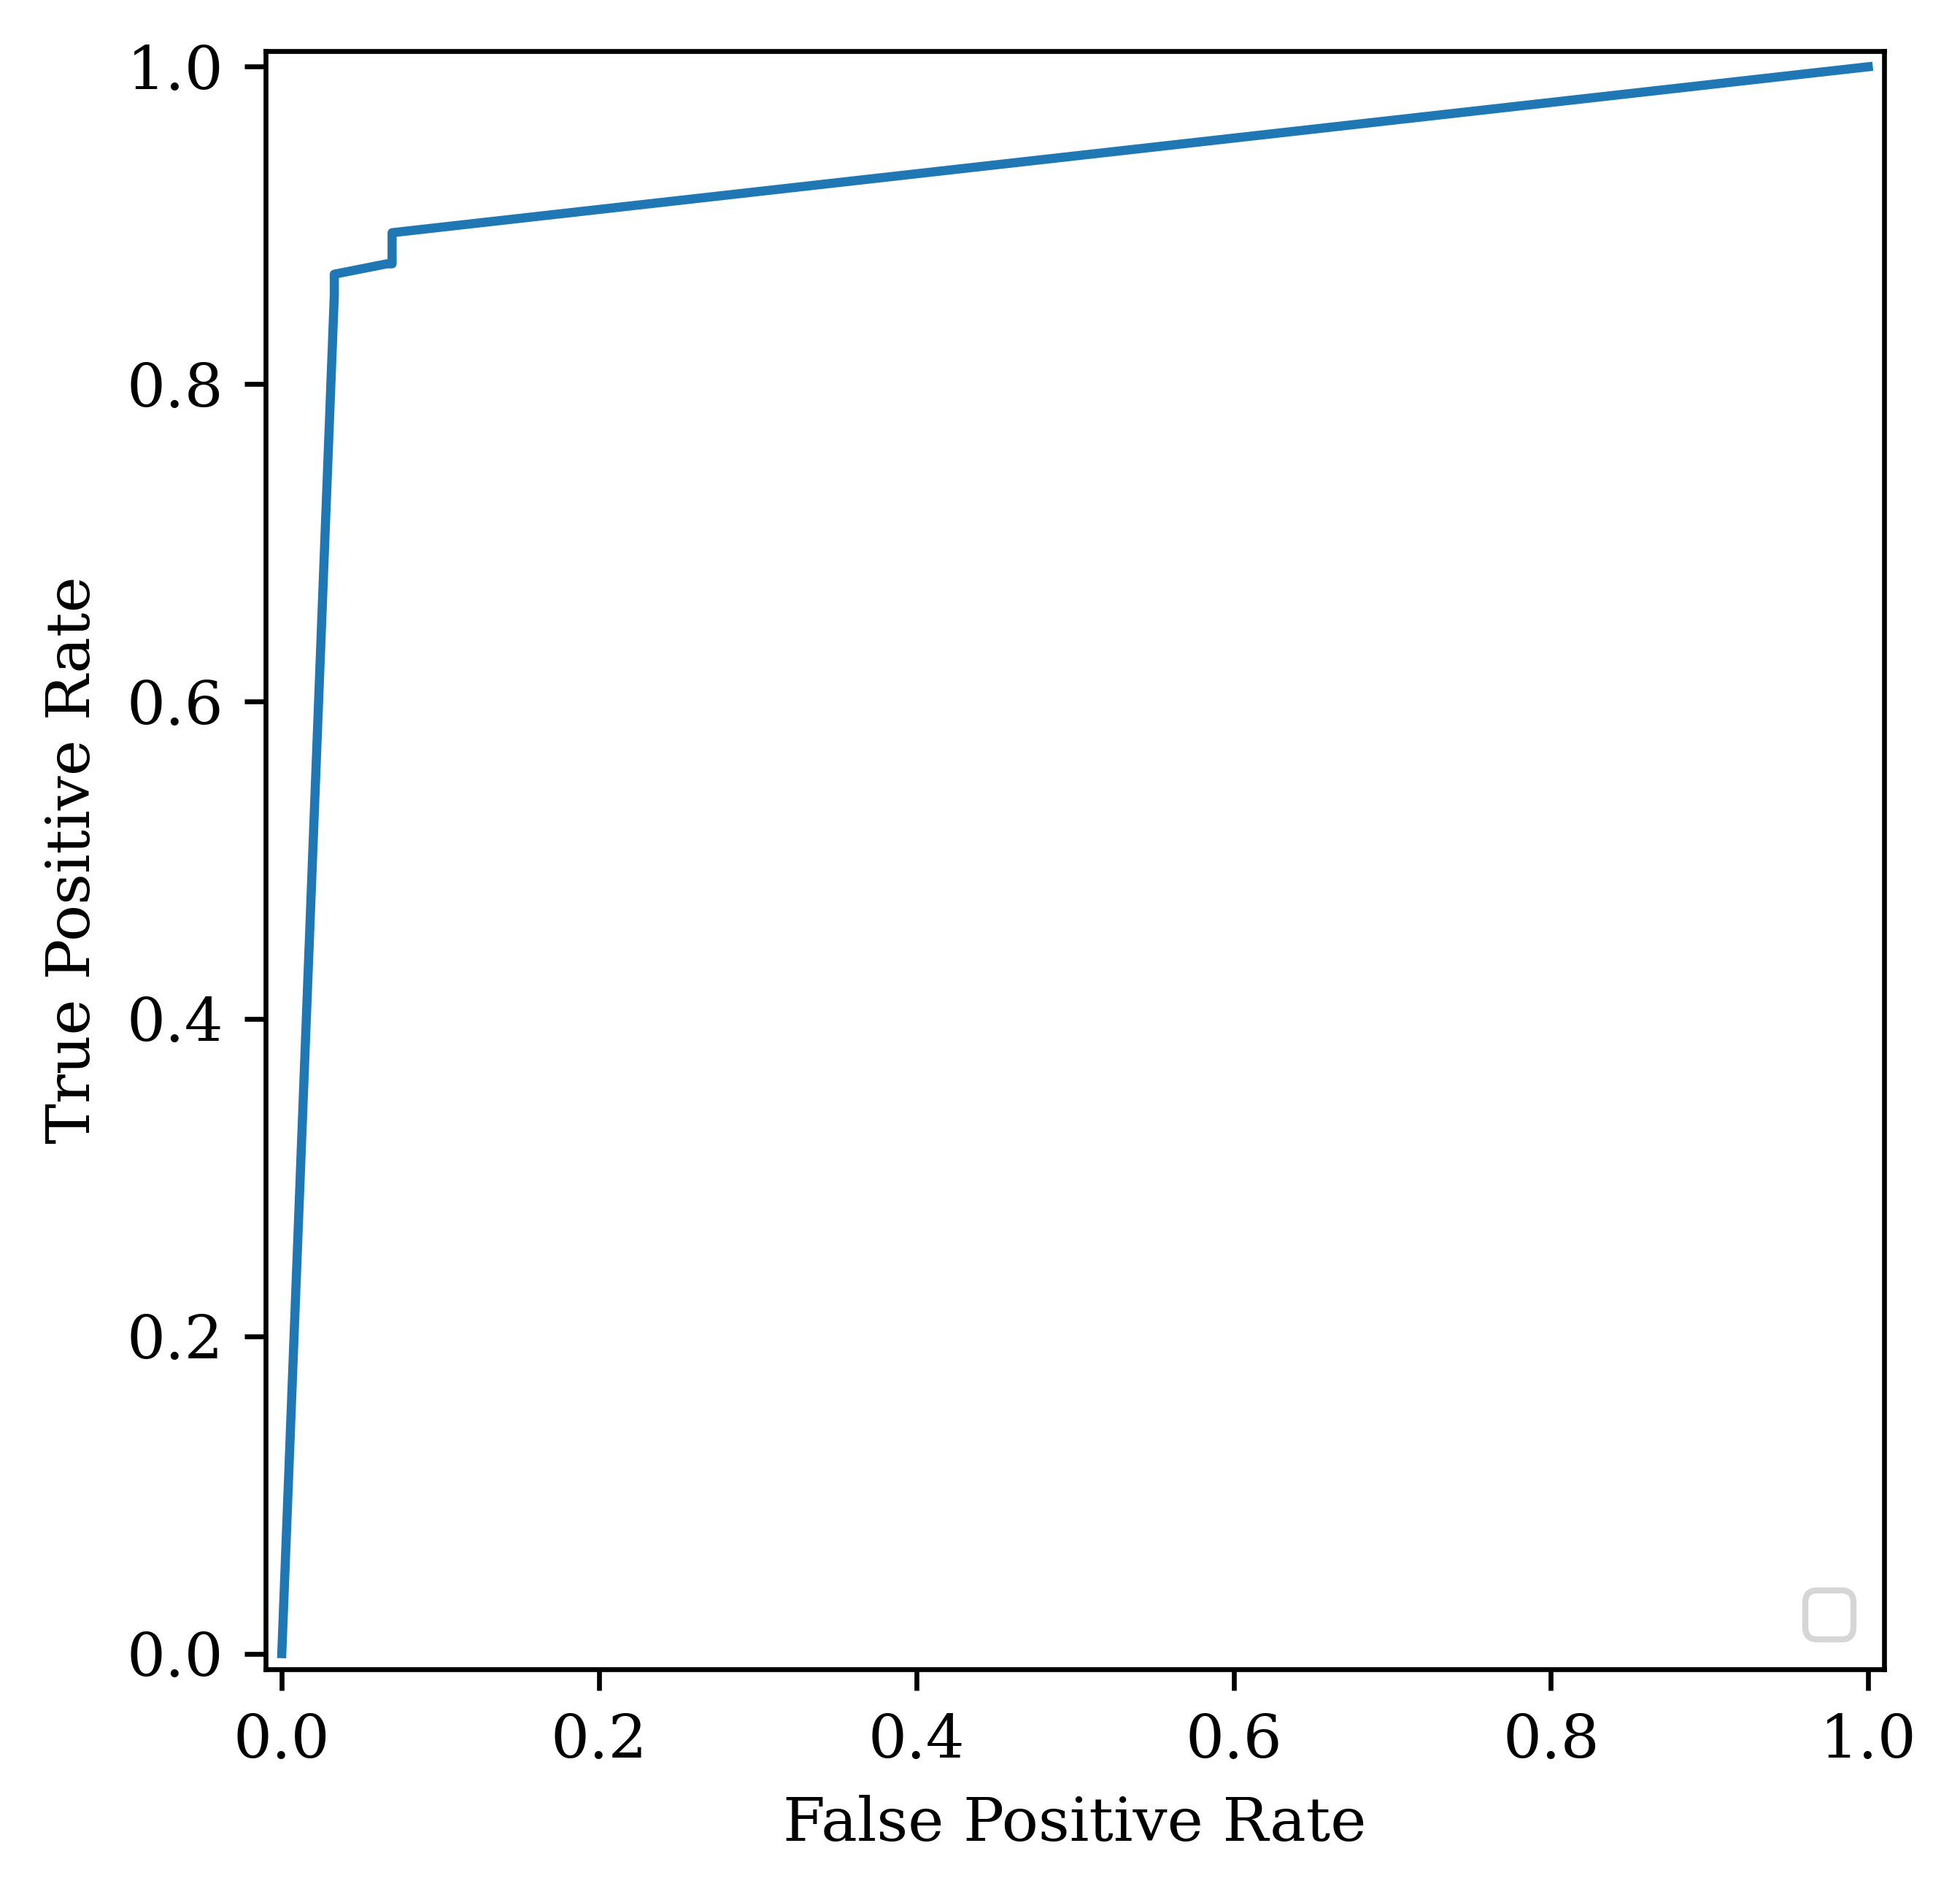

In [391]:
y1_pred_probabilities = clf.predict_proba(X_test)

fpr, tpr, _ = roc_curve(y1_test, y1_pred_probabilities[:,1], pos_label=clf.classes_[1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
roc_auc_score(y1_test, y1_pred_probabilities[:,1])

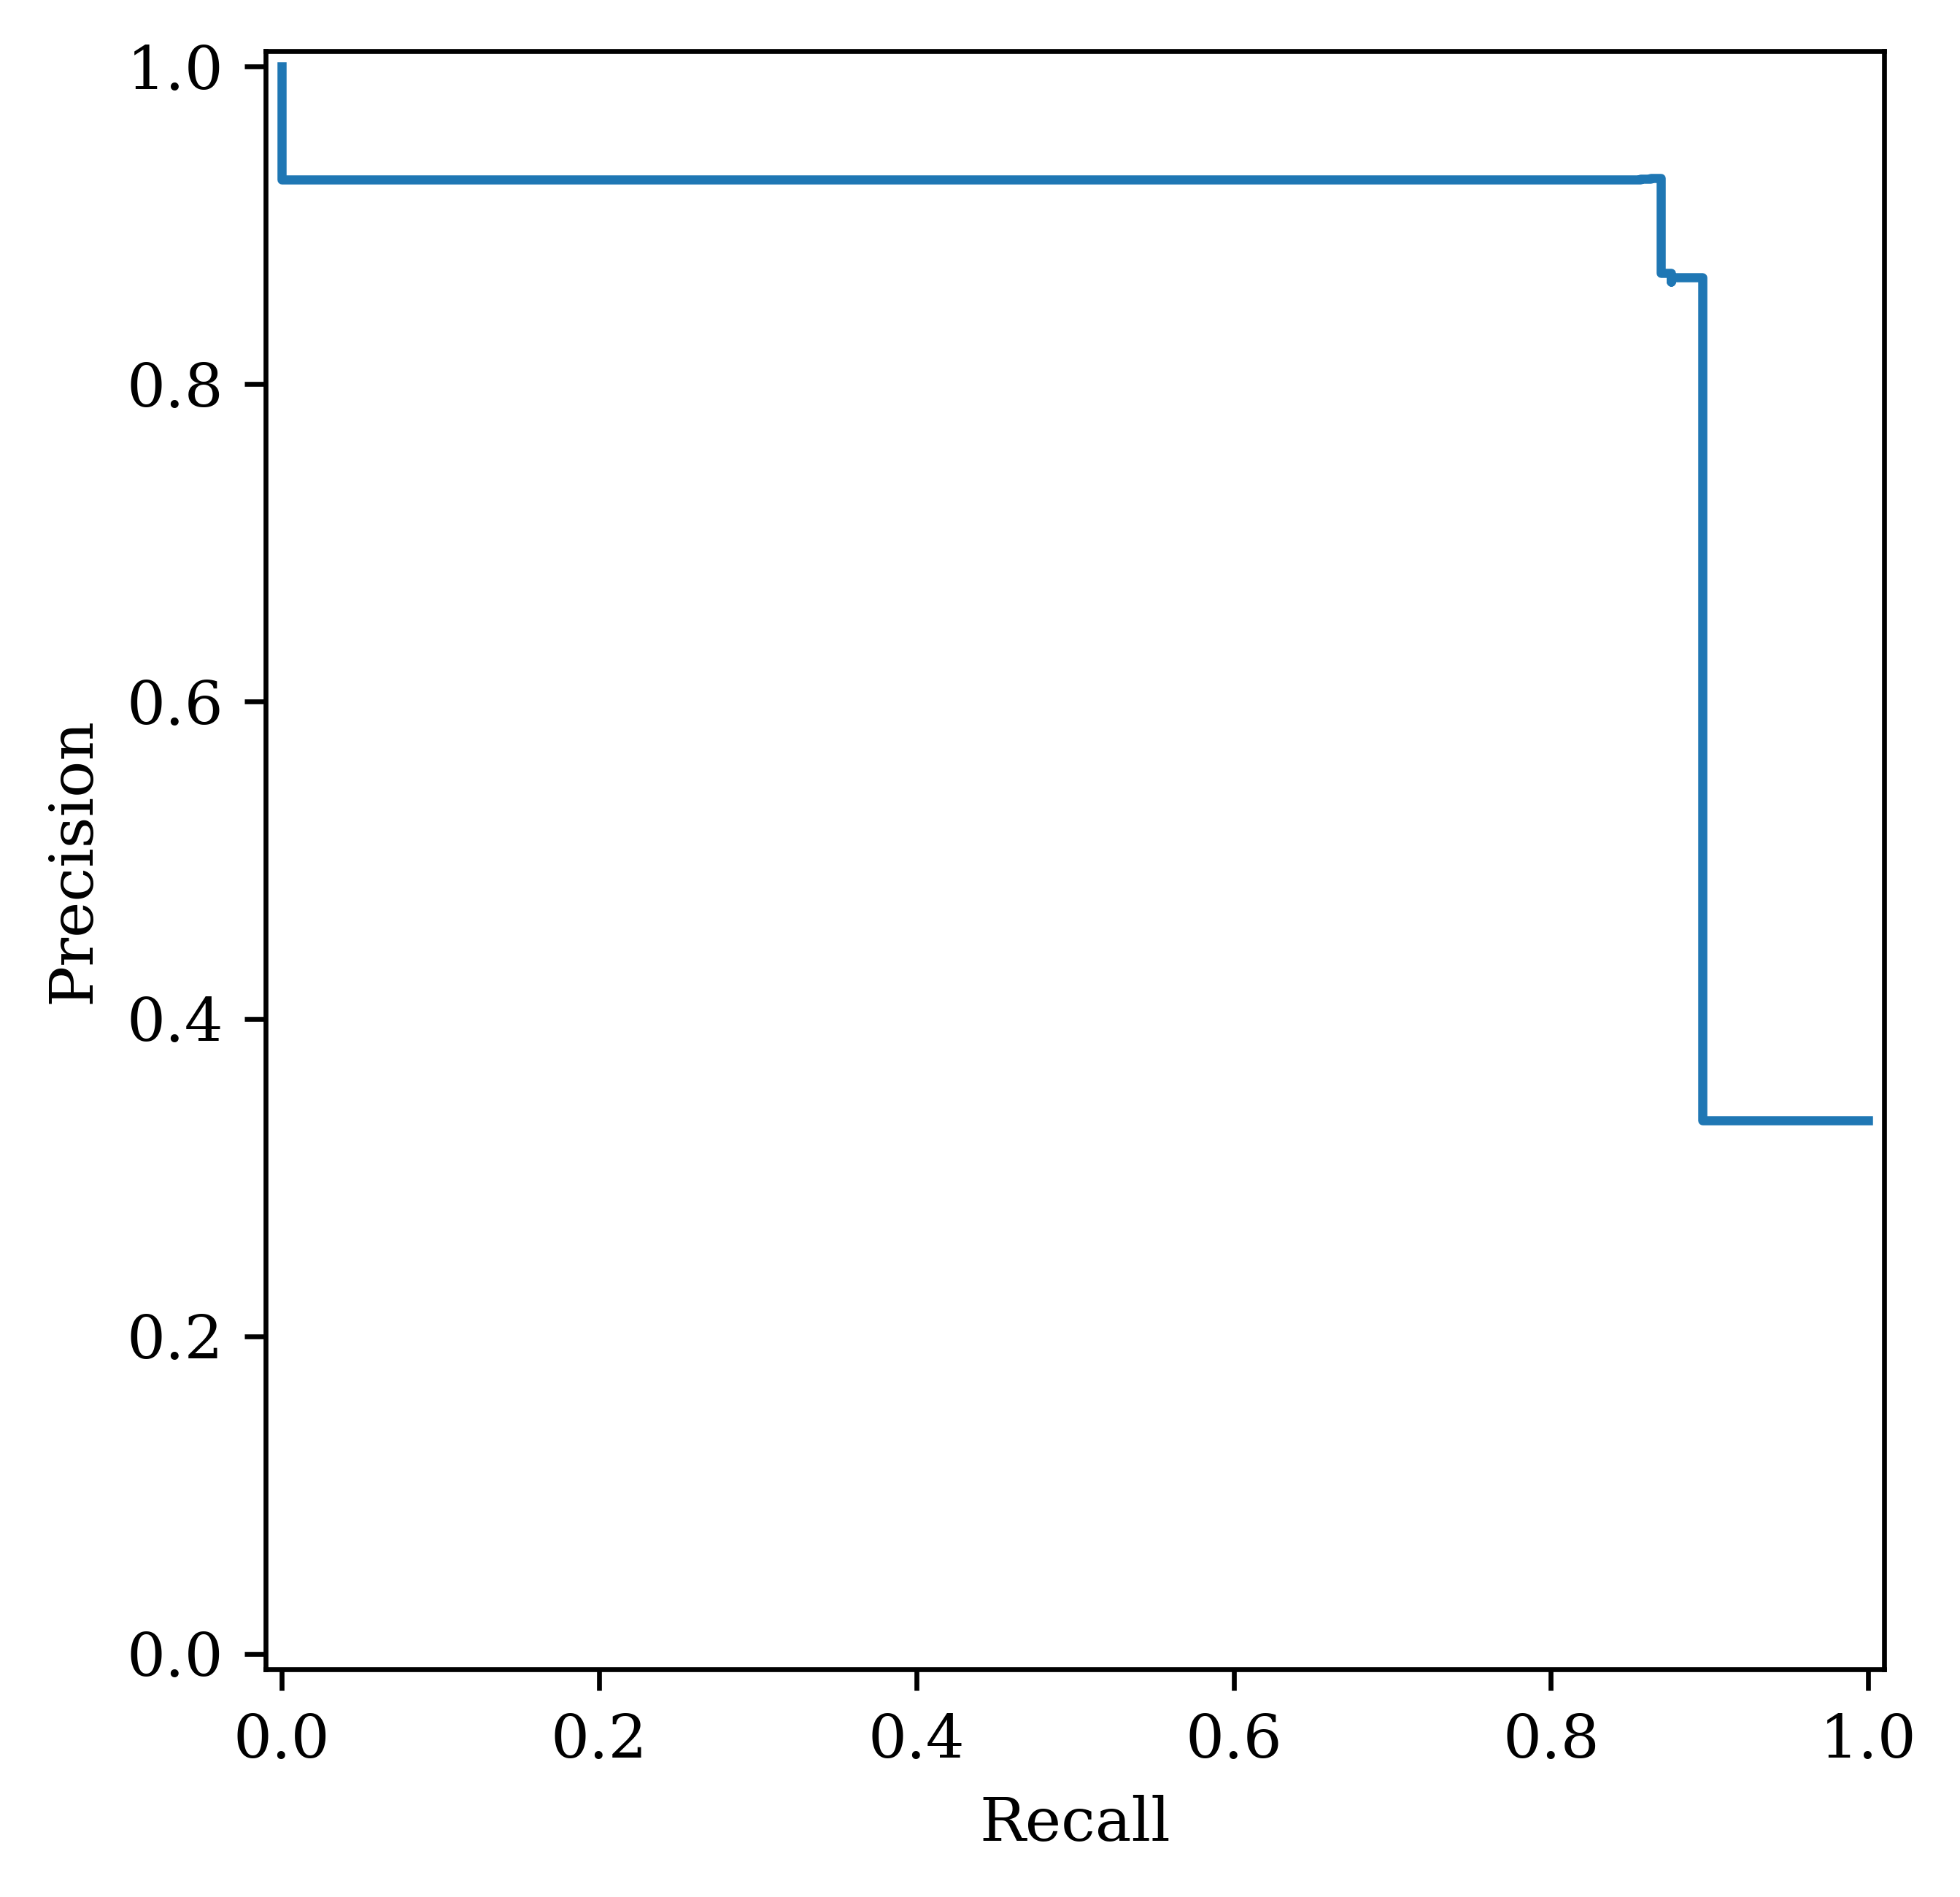

In [392]:
prec, recall, _ = precision_recall_curve(y1_test, y1_pred_probabilities[:,1], pos_label=clf.classes_[1])
pr_display = PrecisionRecallDisplay(precision=prec, recall=recall).plot()

#### Get some statistics about the original runtimes, the rewritten runtimes, the decision runtimes and the true runtimes

In [393]:
test_set = df.loc[y1_test.index]

In [394]:
test_set["decision"] = y1_pred_dec_tree

In [395]:
test_set["ideal runtime"] = np.where(
    (test_set["orig/rewr(med)"] == "orig"), 
    test_set["orig(med)"], 
    test_set["rewr(med)"]
)

test_set["decision runtime"] = np.where(
    (test_set["decision"] == 0), 
    test_set["orig(med)"], 
    test_set["rewr(med)"]
)

In [396]:
test_set

bench                query orig/rewr(med)   orig(med)  rewr(med)  0ma  \
121   STATS  014-134-augF1-full2           orig    0.385583   0.883667    0   
2542  STATS        065-012-augA2           rewr    4.471091   0.460265    1   
28    STATS        004-041-full2           orig    0.202048   0.552705    0   
1942  STATS              016-021           orig    0.242207   0.480087    1   
3726   SNAP  google-tree02-augA1           rewr  100.000000  10.265335    1   
...     ...                  ...            ...         ...        ...  ...   
830   STATS  096-095-augF1-full1           orig    0.419680   1.032125    0   
4165  HETIO   3-01-CbGbCtD-augA1           rewr    0.744715   0.428371    1   
807   STATS  093-075-augF2-full2           orig    0.421795   1.246039    0   
4441  HETIO  9-08-DdGcGpMF-augA3           orig    2.215364   2.329718    1   
704   STATS  082-096-augF1-full1           orig    0.401154   0.900167    0   

      #joins    total cost  min(table rows)  max(table rows)  ...  \
121        4  7.975408e+06            12281           294076  ...   
2542       2  3.596921e+05            37527           178345  ...   
28         3  5.416470e+03                1            80694  ...   
1942       2  1.122034e+04            39380           192676  ...   
3726       5  6.045390e+09          2127100          2127100  ...   
...      ...           ...              ...              ...  ...   
830        3  9.656683e+04            91976           328036  ...   
4165       6  1.621680e+03                1            23142  ...   
807        5  3.897180e+04            17697           328064  ...   
4441       6  3.336490e+04              137           678887  ...   
704        3  7.612800e+04            91976           303157  ...   

      min(branching factors)  max(branching factors)  mean(branching factors)  \
121                        4                       4                      4.0   
2542                       2                       2                      2.0   
28                         3                       3                      3.0   
1942                       2                       2                      2.0   
3726                       2                       3                      2.5   
...                      ...                     ...                      ...   
830                        3                       3                      3.0   
4165                       1                       3                      2.0   
807                        5                       5                      5.0   
4441                       1                       4                      2.0   
704                        3                       3                      3.0   

      median(branching factors)  q25(branching factors)  \
121                         4.0                    4.00   
2542                        2.0                    2.00   
28                          3.0                    3.00   
1942                        2.0                    2.00   
3726                        2.5                    2.25   
...                         ...                     ...   
830                         3.0                    3.00   
4165                        2.0                    1.50   
807                         5.0                    5.00   
4441                        1.0                    1.00   
704                         3.0                    3.00   

      q75(branching factors)  diff rewr-orig  decision  ideal runtime  \
121                     4.00        0.498084         0       0.385583   
2542                    2.00       -4.010826         1       0.460265   
28                      3.00        0.350657         0       0.202048   
1942                    2.00        0.237880         0       0.242207   
3726                    2.75     -100.000000         1      10.265335   
...                      ...             ...       ...            ...   
830                     3.00       

In [397]:
rewrite_slowdowns = test_set.loc[test_set["orig/rewr(med)"] == "orig"]
rewrite_slowdowns

bench                query orig/rewr(med)  orig(med)  rewr(med)  0ma  \
121   STATS  014-134-augF1-full2           orig   0.385583   0.883667    0   
28    STATS        004-041-full2           orig   0.202048   0.552705    0   
1942  STATS              016-021           orig   0.242207   0.480087    1   
1461    JOB       5b-augF1-full3           orig   0.725530   1.664765    0   
495   STATS  057-087-augF2-full2           orig   0.168729   0.439854    0   
...     ...                  ...            ...        ...        ...  ...   
2130  STATS  031-025-augF2-augA2           orig   0.259127   0.459222    1   
830   STATS  096-095-augF1-full1           orig   0.419680   1.032125    0   
807   STATS  093-075-augF2-full2           orig   0.421795   1.246039    0   
4441  HETIO  9-08-DdGcGpMF-augA3           orig   2.215364   2.329718    1   
704   STATS  082-096-augF1-full1           orig   0.401154   0.900167    0   

      #joins  total cost  min(table rows)  max(table rows)  ...  \
121        4  7975407.99            12281           294076  ...   
28         3     5416.47                1            80694  ...   
1942       2    11220.34            39380           192676  ...   
1461       5    72100.52                1               22  ...   
495        2     9627.60            40952            80960  ...   
...      ...         ...              ...              ...  ...   
2130       3    12792.93            11102           101536  ...   
830        3    96566.83            91976           328036  ...   
807        5    38971.80            17697           328064  ...   
4441       6    33364.90              137           678887  ...   
704        3    76128.00            91976           303157  ...   

      min(branching factors)  max(branching factors)  mean(branching factors)  \
121                        4                       4                      4.0   
28                         3                       3                      3.0   
1942                       2                       2                      2.0   
1461                       1                       3                      2.0   
495                        2                       2                      2.0   
...                      ...                     ...                      ...   
2130                       1                       2                      1.5   
830                        3                       3                      3.0   
807                        5                       5                      5.0   
4441                       1                       4                      2.0   
704                        3                       3                      3.0   

      median(branching factors)  q25(branching factors)  \
121                         4.0                    4.00   
28                          3.0                    3.00   
1942                        2.0                    2.00   
1461                        2.0                    1.50   
495                         2.0                    2.00   
...                         ...                     ...   
2130                        1.5                    1.25   
830                         3.0                    3.00   
807                         5.0                    5.00   
4441                        1.0                    1.00   
704                         3.0                    3.00   

      q75(branching factors)  diff rewr-orig  decision  ideal runtime  \
121                     4.00        0.498084         0       0.385583   
28                      3.00        0.350657         0       0.202048   
1942                    2.00        0.237880         0       0.242207   
1461                    2.50        0.939235         0       0.725530   
495                     2.00        0.271126         0       0.168729   
...                      ...             ...       ...            ...   
2130                    1.75        0.200095         0       0.259127  

In [398]:
decision_slowdowns = test_set.loc[test_set["decision runtime"] > test_set["orig(med)"]]
decision_slowdowns

bench                query orig/rewr(med)  orig(med)  rewr(med)  0ma  \
2177  STATS              036-100           orig   0.488549   0.585140    1   
2122  STATS        031-025-augA2           orig   0.498384   0.602948    1   
3890    JOB       2b-augF2-augA4           orig   7.473830   7.623955    1   
2748  STATS        082-096-augF1           orig   0.518653   0.622967    1   
2033  STATS        023-018-augA1           orig   0.440314   0.486031    1   
2666  STATS  075-037-augF2-augA1           orig   0.568208   0.582079    1   
3295  STATS        125-051-augF2           orig   0.362809   0.424699    1   
3378  STATS  130-123-augF2-augA1           orig   0.475431   0.572992    1   
3093  STATS        111-056-augA4           orig   0.437874   0.517919    1   
4035    JOB      17e-augF1-augA5           orig  65.865217  69.379528    1   

      #joins   total cost  min(table rows)  max(table rows)  ...  \
2177       3     15144.63            39433           192979  ...   
2122       3     13707.54            11102           154211  ...   
3890       5      1654.88                1              410  ...   
2748       3     37675.50            38323           178328  ...   
2033       2      9883.40            11102           176636  ...   
2666       3     42885.47            11102           192979  ...   
3295       4  60463443.47             4746            77492  ...   
3378       3      9781.54                1           178345  ...   
3093       4      9834.76                1           192979  ...   
4035       9      2285.24                1              410  ...   

      min(branching factors)  max(branching factors)  mean(branching factors)  \
2177                       1                       2                      1.5   
2122                       1                       2                      1.5   
3890                       1                       3                      2.0   
2748                       1                       2                      1.5   
2033                       1                       1                      1.0   
2666                       3                       3                      3.0   
3295                       1                       3                      2.0   
3378                       1                       2                      1.5   
3093                       1                       3                      2.0   
4035                       2                       2                      2.0   

      median(branching factors)  q25(branching factors)  \
2177                        1.5                    1.25   
2122                        1.5                    1.25   
3890                        2.0                    1.50   
2748                        1.5                    1.25   
2033                        1.0                    1.00   
2666                        3.0                    3.00   
3295                        2.0                    1.50   
3378                        1.5                    1.25   
3093                        2.0                    1.50   
4035                        2.0                    2.00   

      q75(branching factors)  diff rewr-orig  decision  ideal runtime  \
2177                    1.75        0.096590         1       0.488549   
2122                    1.75        0.104564         1       0.498384   
3890                    2.50        0.150126         1       7.473830   
2748                    1.75        0.104313         1       0.518653   
2033                    1.00        0.045717         1       0.440314   
2666                    3.00        0.013871         1       0.568208   
3295                    2.50        0.061890         1       0.362809   
3378                    1.75        0.097561         1       0.475431   
3093                    2.50        0.080045         1       0.437874   
4035                    2.00        3.514311         1      65.865217   

      decision runtime  
2177          0.585140  
21

In [399]:
test_set_0ma = test_set.loc[test_set["0ma"] == 1]
test_set_0ma

bench                query orig/rewr(med)   orig(med)  rewr(med)  0ma  \
2542  STATS        065-012-augA2           rewr    4.471091   0.460265    1   
1942  STATS              016-021           orig    0.242207   0.480087    1   
3726   SNAP  google-tree02-augA1           rewr  100.000000  10.265335    1   
2460  STATS  059-061-augF1-augA1           orig    0.503603   0.662784    1   
3236  STATS        122-071-augA2           rewr    1.244915   0.502648    1   
...     ...                  ...            ...         ...        ...  ...   
2687  STATS              077-004           rewr    0.261534   0.239293    1   
2201  STATS        038-011-augF1           orig    0.233344   0.276217    1   
2130  STATS  031-025-augF2-augA2           orig    0.259127   0.459222    1   
4165  HETIO   3-01-CbGbCtD-augA1           rewr    0.744715   0.428371    1   
4441  HETIO  9-08-DdGcGpMF-augA3           orig    2.215364   2.329718    1   

      #joins    total cost  min(table rows)  max(table rows)  ...  \
2542       2  3.596921e+05            37527           178345  ...   
1942       2  1.122034e+04            39380           192676  ...   
3726       5  6.045390e+09          2127100          2127100  ...   
2460       5  1.567712e+04                1           154090  ...   
3236       5  2.620593e+04            11102           102532  ...   
...      ...           ...              ...              ...  ...   
2687       1  3.907109e+05            42545           102532  ...   
2201       2  2.050209e+04            17928            79504  ...   
2130       3  1.279293e+04            11102           101536  ...   
4165       6  1.621680e+03                1            23142  ...   
4441       6  3.336490e+04              137           678887  ...   

      min(branching factors)  max(branching factors)  mean(branching factors)  \
2542                       2                       2                      2.0   
1942                       2                       2                      2.0   
3726                       2                       3                      2.5   
2460                       5                       5                      5.0   
3236                       1                       4                      2.5   
...                      ...                     ...                      ...   
2687                       1                       1                      1.0   
2201                       2                       2                      2.0   
2130                       1                       2                      1.5   
4165                       1                       3                      2.0   
4441                       1                       4                      2.0   

      median(branching factors)  q25(branching factors)  \
2542                        2.0                    2.00   
1942                        2.0                    2.00   
3726                        2.5                    2.25   
2460                        5.0                    5.00   
3236                        2.5                    1.75   
...                         ...                     ...   
2687                        1.0                    1.00   
2201                        2.0                    2.00   
2130                        1.5                    1.25   
4165                        2.0                    1.50   
4441                        1.0                    1.00   

      q75(branching factors)  diff rewr-orig  decision  ideal runtime  \
2542                    2.00       -4.010826         1       0.460265   
1942                    2.00        0.237880         0       0.242207   
3726                    2.75     -100.000000         1      10.265335   
2460                    5.00        0.159182         0       0.503603   
3236                    3.25       -0.742267         1       0.502648   
...                      ...             ...       ...            ...   
2687                    1.00       

In [400]:
test_set_enum = test_set.loc[test_set["0ma"] == 0]
test_set_enum

bench                query orig/rewr(med)  orig(med)  rewr(med)  0ma  \
121   STATS  014-134-augF1-full2           orig   0.385583   0.883667    0   
28    STATS        004-041-full2           orig   0.202048   0.552705    0   
1461    JOB       5b-augF1-full3           orig   0.725530   1.664765    0   
495   STATS  057-087-augF2-full2           orig   0.168729   0.439854    0   
8     STATS  001-014-augF2-full3           orig   0.216572   0.549869    0   
...     ...                  ...            ...        ...        ...  ...   
962   STATS        113-113-full2           orig   0.341199   0.775248    0   
593   STATS  068-121-augF2-full1           orig   0.200775   0.602621    0   
830   STATS  096-095-augF1-full1           orig   0.419680   1.032125    0   
807   STATS  093-075-augF2-full2           orig   0.421795   1.246039    0   
704   STATS  082-096-augF1-full1           orig   0.401154   0.900167    0   

      #joins  total cost  min(table rows)  max(table rows)  ...  \
121        4  7975407.99            12281           294076  ...   
28         3     5416.47                1            80694  ...   
1461       5    72100.52                1               22  ...   
495        2     9627.60            40952            80960  ...   
8          2    11475.41                1           168966  ...   
...      ...         ...              ...              ...  ...   
962        3  1025524.29            39936           303187  ...   
593        3    26178.50             5869            84973  ...   
830        3    96566.83            91976           328036  ...   
807        5    38971.80            17697           328064  ...   
704        3    76128.00            91976           303157  ...   

      min(branching factors)  max(branching factors)  mean(branching factors)  \
121                        4                       4                      4.0   
28                         3                       3                      3.0   
1461                       1                       3                      2.0   
495                        2                       2                      2.0   
8                          2                       2                      2.0   
...                      ...                     ...                      ...   
962                        3                       3                      3.0   
593                        3                       3                      3.0   
830                        3                       3                      3.0   
807                        5                       5                      5.0   
704                        3                       3                      3.0   

      median(branching factors)  q25(branching factors)  \
121                         4.0                     4.0   
28                          3.0                     3.0   
1461                        2.0                     1.5   
495                         2.0                     2.0   
8                           2.0                     2.0   
...                         ...                     ...   
962                         3.0                     3.0   
593                         3.0                     3.0   
830                         3.0                     3.0   
807                         5.0                     5.0   
704                         3.0                     3.0   

      q75(branching factors)  diff rewr-orig  decision  ideal runtime  \
121                      4.0        0.498084         0       0.385583   
28                       3.0        0.350657         0       0.202048   
1461                     2.5        0.939235         0       0.725530   
495                      2.0        0.271126         0       0.168729   
8                        2.0        0.333298         0       0.216572   
...                      ...             ...       ...            ...   
962                      3.0        0.434048         0       0.341199  

In [401]:
def get_summary(test_set):
    summary_data = {
    "orig": [
        test_set["orig(med)"].sum(),
        test_set["orig(med)"].mean(),
        test_set["orig(med)"].min(),
        test_set["orig(med)"].max(),
        test_set["orig(med)"].median(),
        test_set["orig(med)"].std()
    ],
    "rewr": [
        test_set["rewr(med)"].sum(),
        test_set["rewr(med)"].mean(),
        test_set["rewr(med)"].min(),
        test_set["rewr(med)"].max(),
        test_set["rewr(med)"].median(),
        test_set["rewr(med)"].std()
    ],
    "dec": [
        test_set["decision runtime"].sum(),
        test_set["decision runtime"].mean(),
        test_set["decision runtime"].min(),
        test_set["decision runtime"].max(),
        test_set["decision runtime"].median(),
        test_set["decision runtime"].std()
    ],
    "true": [
        test_set["ideal runtime"].sum(),
        test_set["ideal runtime"].mean(),
        test_set["ideal runtime"].min(),
        test_set["ideal runtime"].max(),
        test_set["ideal runtime"].median(),
        test_set["ideal runtime"].std()
    ]
    }
    return summary_data

summary_data = get_summary(test_set)

# Create a DataFrame using the summary data
summary_table = pd.DataFrame(
    summary_data,
    index=["sum", "mean","median", "std", "min", "max"]
)

# Display the table
summary_table

orig         rewr          dec         true
sum     5616.461590  2072.061482  1735.473716  1729.328317
mean      12.343872     4.553981     3.814228     3.800722
median     0.057320     0.124816     0.057320     0.057320
std      248.136526   100.000000    84.489570    84.489570
min        0.503603     0.664124     0.466077     0.462922
max       30.713637    13.538903    12.288580    12.248911

In [402]:
summary_data = get_summary(test_set_0ma)

# Create a DataFrame using the summary data
summary_table = pd.DataFrame(
    summary_data,
    index=["sum", "mean","median", "std", "min", "max"]
)

# Display the table
summary_table

orig         rewr          dec         true
sum     4760.102751  1325.112556  1180.797620  1174.652221
mean      16.357741     4.553651     4.057724     4.036606
median     0.081189     0.124816     0.081189     0.081189
std      248.136526    84.489570    84.489570    84.489570
min        0.616329     0.588343     0.544789     0.534729
max       34.802766    13.173102    11.935954    11.872376

In [403]:
summary_data = get_summary(test_set_enum)

# Create a DataFrame using the summary data
summary_table = pd.DataFrame(
    summary_data,
    index=["sum", "mean","median", "std", "min", "max"]
)

# Display the table
summary_table

orig        rewr         dec        true
sum     856.358839  746.948926  554.676096  554.676096
mean      5.221700    4.554567    3.382171    3.382171
median    0.057320    0.163880    0.057320    0.057320
std     100.000000  100.000000   81.025448   81.025448
min       0.348060    0.839522    0.348060    0.348060
max      19.816019   14.206018   12.916646   12.916646

#### Inspection of the misclassifications

In [404]:
misclass = df.loc[X_test.index]
misclass.insert(0, 'true label', np.array(y1_test))
misclass.insert(0, 'pred label', y1_pred_dec_tree)
indices_not_equal = np.where(y1_test != y1_pred_dec_tree)[0]
misclass = misclass.iloc[indices_not_equal]
misclass

pred label  true label  bench                query orig/rewr(med)  \
3955           0           1    JOB       3c-augF2-augA2           rewr   
2177           1           0  STATS              036-100           orig   
2122           1           0  STATS        031-025-augA2           orig   
3890           1           0    JOB       2b-augF2-augA4           orig   
3407           0           1  STATS  132-105-augF1-augA1           rewr   
2748           1           0  STATS        082-096-augF1           orig   
2649           0           1  STATS  074-072-augF1-augA4           rewr   
2033           1           0  STATS        023-018-augA1           orig   
3095           0           1  STATS  111-056-augF1-augA1           rewr   
2837           0           1  STATS        090-079-augA3           rewr   
2666           1           0  STATS  075-037-augF2-augA1           orig   
3295           1           0  STATS        125-051-augF2           orig   
3378           1           0  STATS  130-123-augF2-augA1           orig   
2943           0           1  STATS  097-077-augF2-augA2           rewr   
2655           0           1  STATS  074-072-augF2-augA4           rewr   
2537           0           1  STATS  064-116-augF2-augA1           rewr   
3093           1           0  STATS        111-056-augA4           orig   
4035           1           0    JOB      17e-augF1-augA5           orig   
2093           0           1  STATS  028-062-augF1-augA3           rewr   
2923           0           1  STATS        096-095-augA2           rewr   
2856           0           1  STATS        091-035-augF1           rewr   
3948           0           1    JOB             3c-augA3           rewr   
2141           0           1  STATS  032-086-augF2-augA1           rewr   
2684           0           1  STATS  076-073-augF2-augA3           rewr   
2879           0           1  STATS        093-075-augA3           rewr   
3947           0           1    JOB             3c-augA2           rewr   
2289           0           1  STATS  044-145-augF2-augA4           rewr   
2643           0           1  STATS        074-072-augA4           rewr   
2891           0           1  STATS  093-075-augF2-augA3           rewr   
4203           0           1  HETIO   3-06-CdGuCtD-augA4           rewr   

      orig(med)  rewr(med)  0ma  #joins   total cost  ...  \
3955   7.145910   6.824363    1       4     24614.09  ...   
2177   0.488549   0.585140    1       3     15144.63  ...   
2122   0.498384   0.602948    1       3     13707.54  ...   
3890   7.473830   7.623955    1       5      1654.88  ...   
3407   0.483011   0.450714    1       3   1949536.17  ...   
2748   0.518653   0.622967    1       3     37675.50  ...   
2649   0.765939   0.550685    1       5     16656.66  ...   
2033   0.440314   0.486031    1       2      9883.40  ...   
3095   0.502556   0.490585    1       4      9793.81  ...   
2837   0.663305   0.652557    1       5     27749.80  ...   
2666   0.568208   0.582079    1       3     42885.47  ...   
3295   0.362809   0.424699    1       4  60463443.47  ...   
3378   0.475431   0.572992    1       3      9781.54  ...   
2943   0.625440   0.520549    1       5     18756.80  ...   
2655   0.657887   0.548614    1       5     15363.56  ...   
2537   0.299220   0.285203    1       3    377638.11  ...   
3093   0.437874   0.517919    1       4      9834.76  ...   
4035  65.865217  69.379528    1       9      2285.24  ...   
2093   0.586381   0.379778    1       5     11955.63  ...   
2923   0.618570   0.603146    1       3     51648.49  ...   
2856   0.290070   0.279717    1       3     18393.17  ...   
3948   7.867295   7.711993    1       4     24671.69  ...   
2141   0.546114   0.497367    1       3     13065.89  ...   
2684   0.601206   0.493895    1       5     18106.14  ...   
2879   0.703205   0.688308    1       5     42778.84  ...   
3947   7.040404   6.883858    1       4     24671.69  ...   
2289   0.664128   0.556655    1  

In [405]:
print("Default font size:", plt.rcParams['font.size'])

Default font size: 10.0


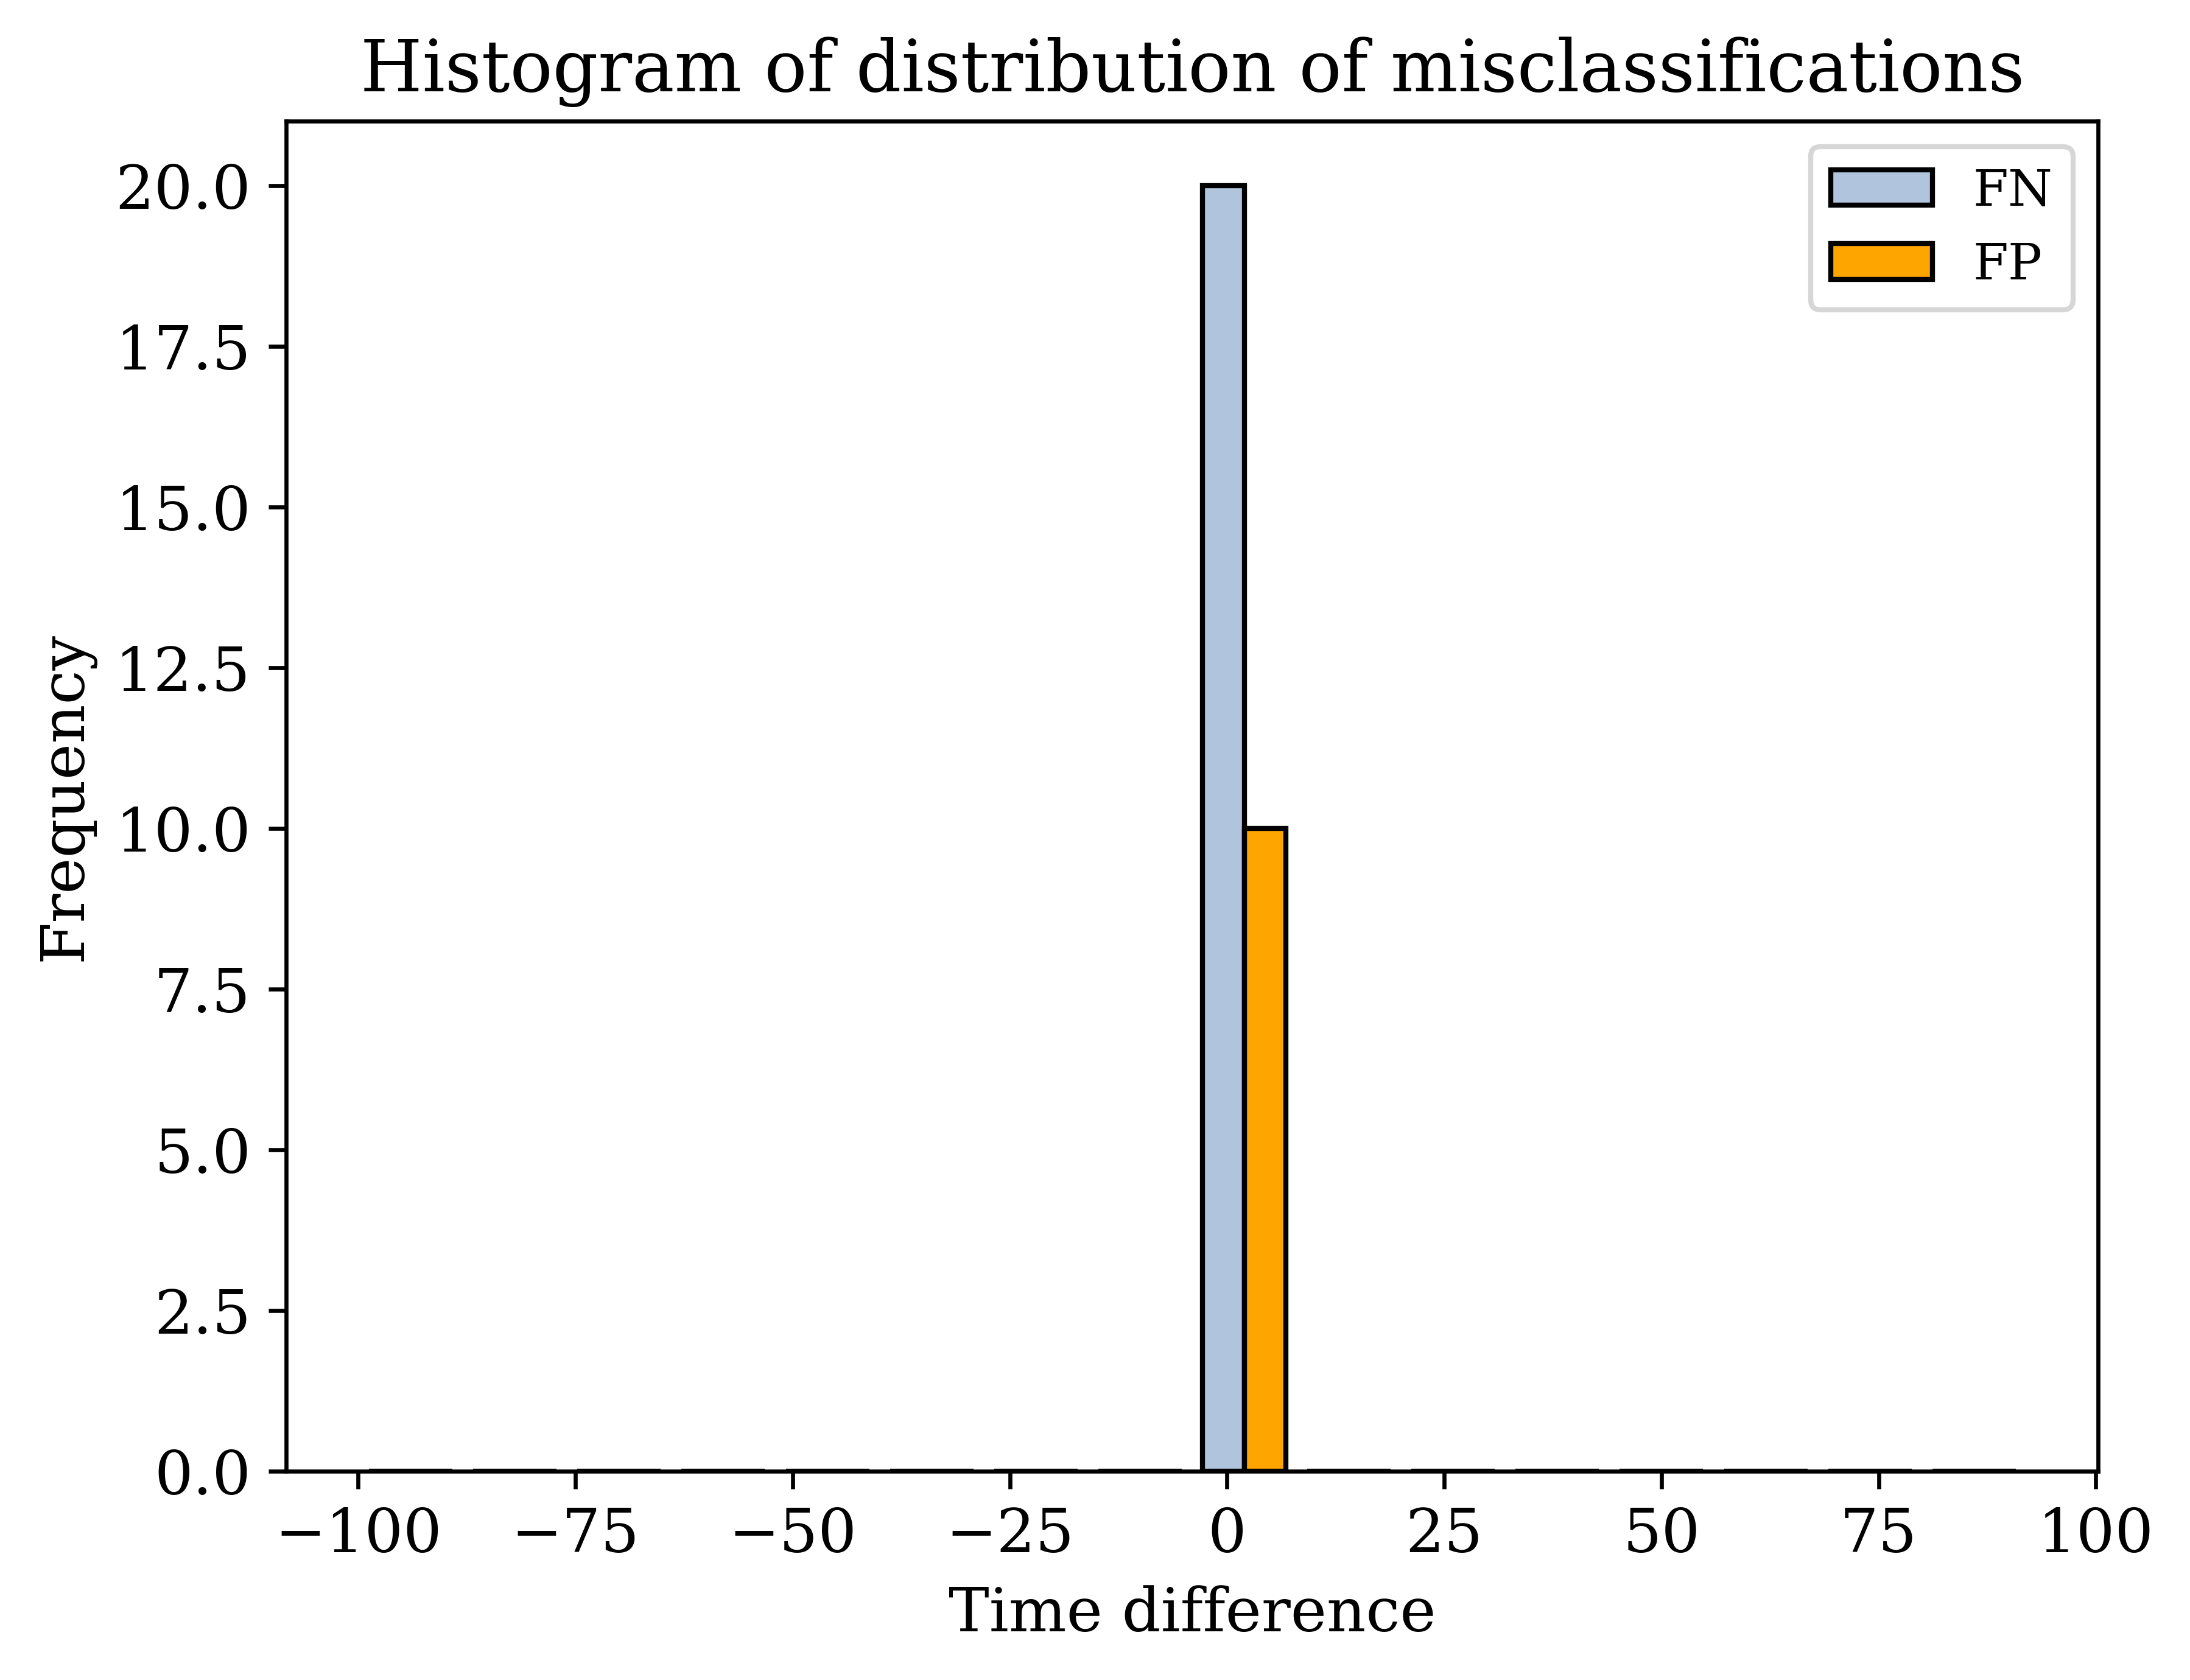

In [406]:
diff_0 = misclass[misclass['pred label'] == 0]['diff rewr-orig']
diff_1 = misclass[misclass['pred label'] == 1]['diff rewr-orig']

# Plotting the histogram
bins=list(range(-100, 101, 12))
plt.hist([diff_0, diff_1], bins=bins, edgecolor='black', color=['lightsteelblue', 'orange'], label=['FN', 'FP'])

# Adding labels and title
plt.xlabel('Time difference', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.title('Histogram of distribution of misclassifications', fontsize = 14)
plt.legend(title='')
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12)

plt.savefig('plots/SPA_extra_all_dec_tree_misclass_hist.png')
# Show the plot
plt.show()

In [407]:
bins = [0, 0.01, 0.1, 1, 10, 99.99, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']

misclass_1 = misclass[misclass["pred label"] == 1]
misclass_0 = misclass[misclass["pred label"] == 0]

misclass_1["cut"] = pd.cut(abs(misclass_1['diff rewr-orig']), bins=bins, labels=labels)
misclass_0["cut"] = pd.cut(abs(misclass_0['diff rewr-orig']), bins=bins, labels=labels)

table_1 = misclass_1.groupby('cut').size().reset_index(name='count_1')
table_0 = misclass_0.groupby('cut').size().reset_index(name='count_0')

table = pd.merge(table_1, table_0, on='cut', how='outer')
table = table.set_index('cut').T
table.index = ['FP', 'FN']
table

/tmp/ipykernel_39050/2371796600.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclass_1["cut"] = pd.cut(abs(misclass_1['diff rewr-orig']), bins=bins, labels=labels)
/tmp/ipykernel_39050/2371796600.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  misclass_0["cut"] = pd.cut(abs(misclass_0['diff rewr-orig']), bins=bins, labels=labels)
/tmp/ipykernel_39050/2371796600.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observ

cut  0.01  0.1   1  10  100  TO
FP      0    6   3   1    0   0
FN      1    9  10   0    0   0

#### Statistical tests

In [408]:
test_set = df.loc[X_test.index]
test_set.insert(0, 'true label', np.array(y1_test))
test_set.insert(0, 'pred label', y1_pred_dec_tree)

In [409]:
test_set['pred(med)'] = np.where(test_set['pred label'] == 0, test_set['orig(med)'], test_set['rewr(med)'])
test_set.head()

pred label  true label  bench                query orig/rewr(med)  \
121            0           0  STATS  014-134-augF1-full2           orig   
2542           1           1  STATS        065-012-augA2           rewr   
28             0           0  STATS        004-041-full2           orig   
1942           0           0  STATS              016-021           orig   
3726           1           1   SNAP  google-tree02-augA1           rewr   

       orig(med)  rewr(med)  0ma  #joins    total cost  ...  \
121     0.385583   0.883667    0       4  7.975408e+06  ...   
2542    4.471091   0.460265    1       2  3.596921e+05  ...   
28      0.202048   0.552705    0       3  5.416470e+03  ...   
1942    0.242207   0.480087    1       2  1.122034e+04  ...   
3726  100.000000  10.265335    1       5  6.045390e+09  ...   

      median(container counts)  q75(container counts)  min(branching factors)  \
121                        1.0                    1.0                       4   
2542                       1.0                    1.0                       2   
28                         1.0                    1.0                       3   
1942                       1.0                    1.0                       2   
3726                       1.0                    1.0                       2   

      max(branching factors)  mean(branching factors)  \
121                        4                      4.0   
2542                       2                      2.0   
28                         3                      3.0   
1942                       2                      2.0   
3726                       3                      2.5   

      median(branching factors)  q25(branching factors)  \
121                         4.0                    4.00   
2542                        2.0                    2.00   
28                          3.0                    3.00   
1942                        2.0                    2.00   
3726                        2.5                    2.25   

      q75(branching factors)  diff rewr-orig  pred(med)  
121                     4.00        0.498084   0.385583  
2542                    2.00       -4.010826   0.460265  
28                      3.00        0.350657   0.202048  
1942                    2.00        0.237880   0.242207  
3726                    2.75     -100.000000  10.265335  

[5 rows x 37 columns]

The Wilcoxon rank test is to compare medians (of dependent groups).  
The Nullhypothesis is that the medians are equal. If the p-value is smaller than a chosen alpha value, we can reject the null and say that the median with only original runtimes is significantly different to the median of the chosen versions.

### Predicted vs. orig

In [410]:
w_stat, p_val = stats.wilcoxon(test_set["orig(med)"], test_set["pred(med)"])

print(f"Wilcoxon statistic: {w_stat}")
print(f"P-value: {p_val}")

Wilcoxon statistic: 195.0
P-value: 1.8418339200911663e-23


The paired sample t-test is to compare means (of dependent groups).  
The Nullhypothesis is that the means are equal. If the p-value is smaller than a chosen alpha value, we can reject the null and say that the mean with only original runtimes is significantly different to the mean of the chosen versions.

In [411]:
t_stat, p_val = stats.ttest_rel(test_set["orig(med)"], test_set["pred(med)"])

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_val}")

T-statistic: 7.045064952308863
P-value: 6.915157746237714e-12


### Predicted vs. always rewriting

In [423]:
w_stat, p_val = stats.wilcoxon(test_set["rewr(med)"], test_set["pred(med)"])

print(f"Wilcoxon statistic: {w_stat}")
print(f"P-value: {p_val}")

t_stat, p_val = stats.ttest_rel(test_set["rewr(med)"], test_set["pred(med)"])

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_val}")

Wilcoxon statistic: 1189.0
P-value: 4.779570425238221e-48
T-statistic: 5.30038749450123
P-value: 1.8070149150875576e-07


#### Important features using Gini importance

In [412]:
feature_names = X.columns.tolist()
feature_importances = clf.feature_importances_
df_importances = pd.DataFrame(data=feature_importances, index=feature_names, columns=["Importance"])
df_importances.T

0ma  #joins  total cost  min(table rows)  max(table rows)  \
Importance  0.245915  0.1345    0.091743         0.005174         0.037025   

            mean(table rows)  q25(table rows)  median(table rows)  \
Importance          0.015171         0.053027             0.04433   

            q75(table rows)  min(join rows)  ...  mean(container counts)  \
Importance         0.014741        0.016466  ...                0.031768   

            q25(container counts)  median(container counts)  \
Importance                    0.0                       0.0   

            q75(container counts)  min(branching factors)  \
Importance                    0.0                0.002329   

            max(branching factors)  mean(branching factors)  \
Importance                0.004038                 0.001374   

            median(branching factors)  q25(branching factors)  \
Importance                   0.003604                0.005783   

            q75(branching factors)  
Importance                0.007324  

[1 rows x 28 columns]

In [413]:
df_importances_sorted = df_importances.sort_values(by='Importance', ascending=False)  # Use ascending=True for ascending order
df_importances_sorted

Importance
0ma                          0.245915
max(join rows)               0.212465
#joins                       0.134500
total cost                   0.091743
q25(table rows)              0.053027
median(table rows)           0.044330
max(table rows)              0.037025
mean(container counts)       0.031768
q25(join rows)               0.025513
median(join rows)            0.021181
min(join rows)               0.016466
mean(join rows)              0.015728
mean(table rows)             0.015171
q75(table rows)              0.014741
q75(branching factors)       0.007324
depth                        0.007040
q25(branching factors)       0.005783
min(table rows)              0.005174
max(branching factors)       0.004038
median(branching factors)    0.003604
q75(join rows)               0.003286
min(branching factors)       0.002329
mean(branching factors)      0.001374
max(container counts)        0.000474
min(container counts)        0.000000
q25(container counts)        0.000000
median(container counts)     0.000000
q75(container counts)        0.000000

#### Visualization of the decision tree

In [414]:
clf.tree_.max_depth

20

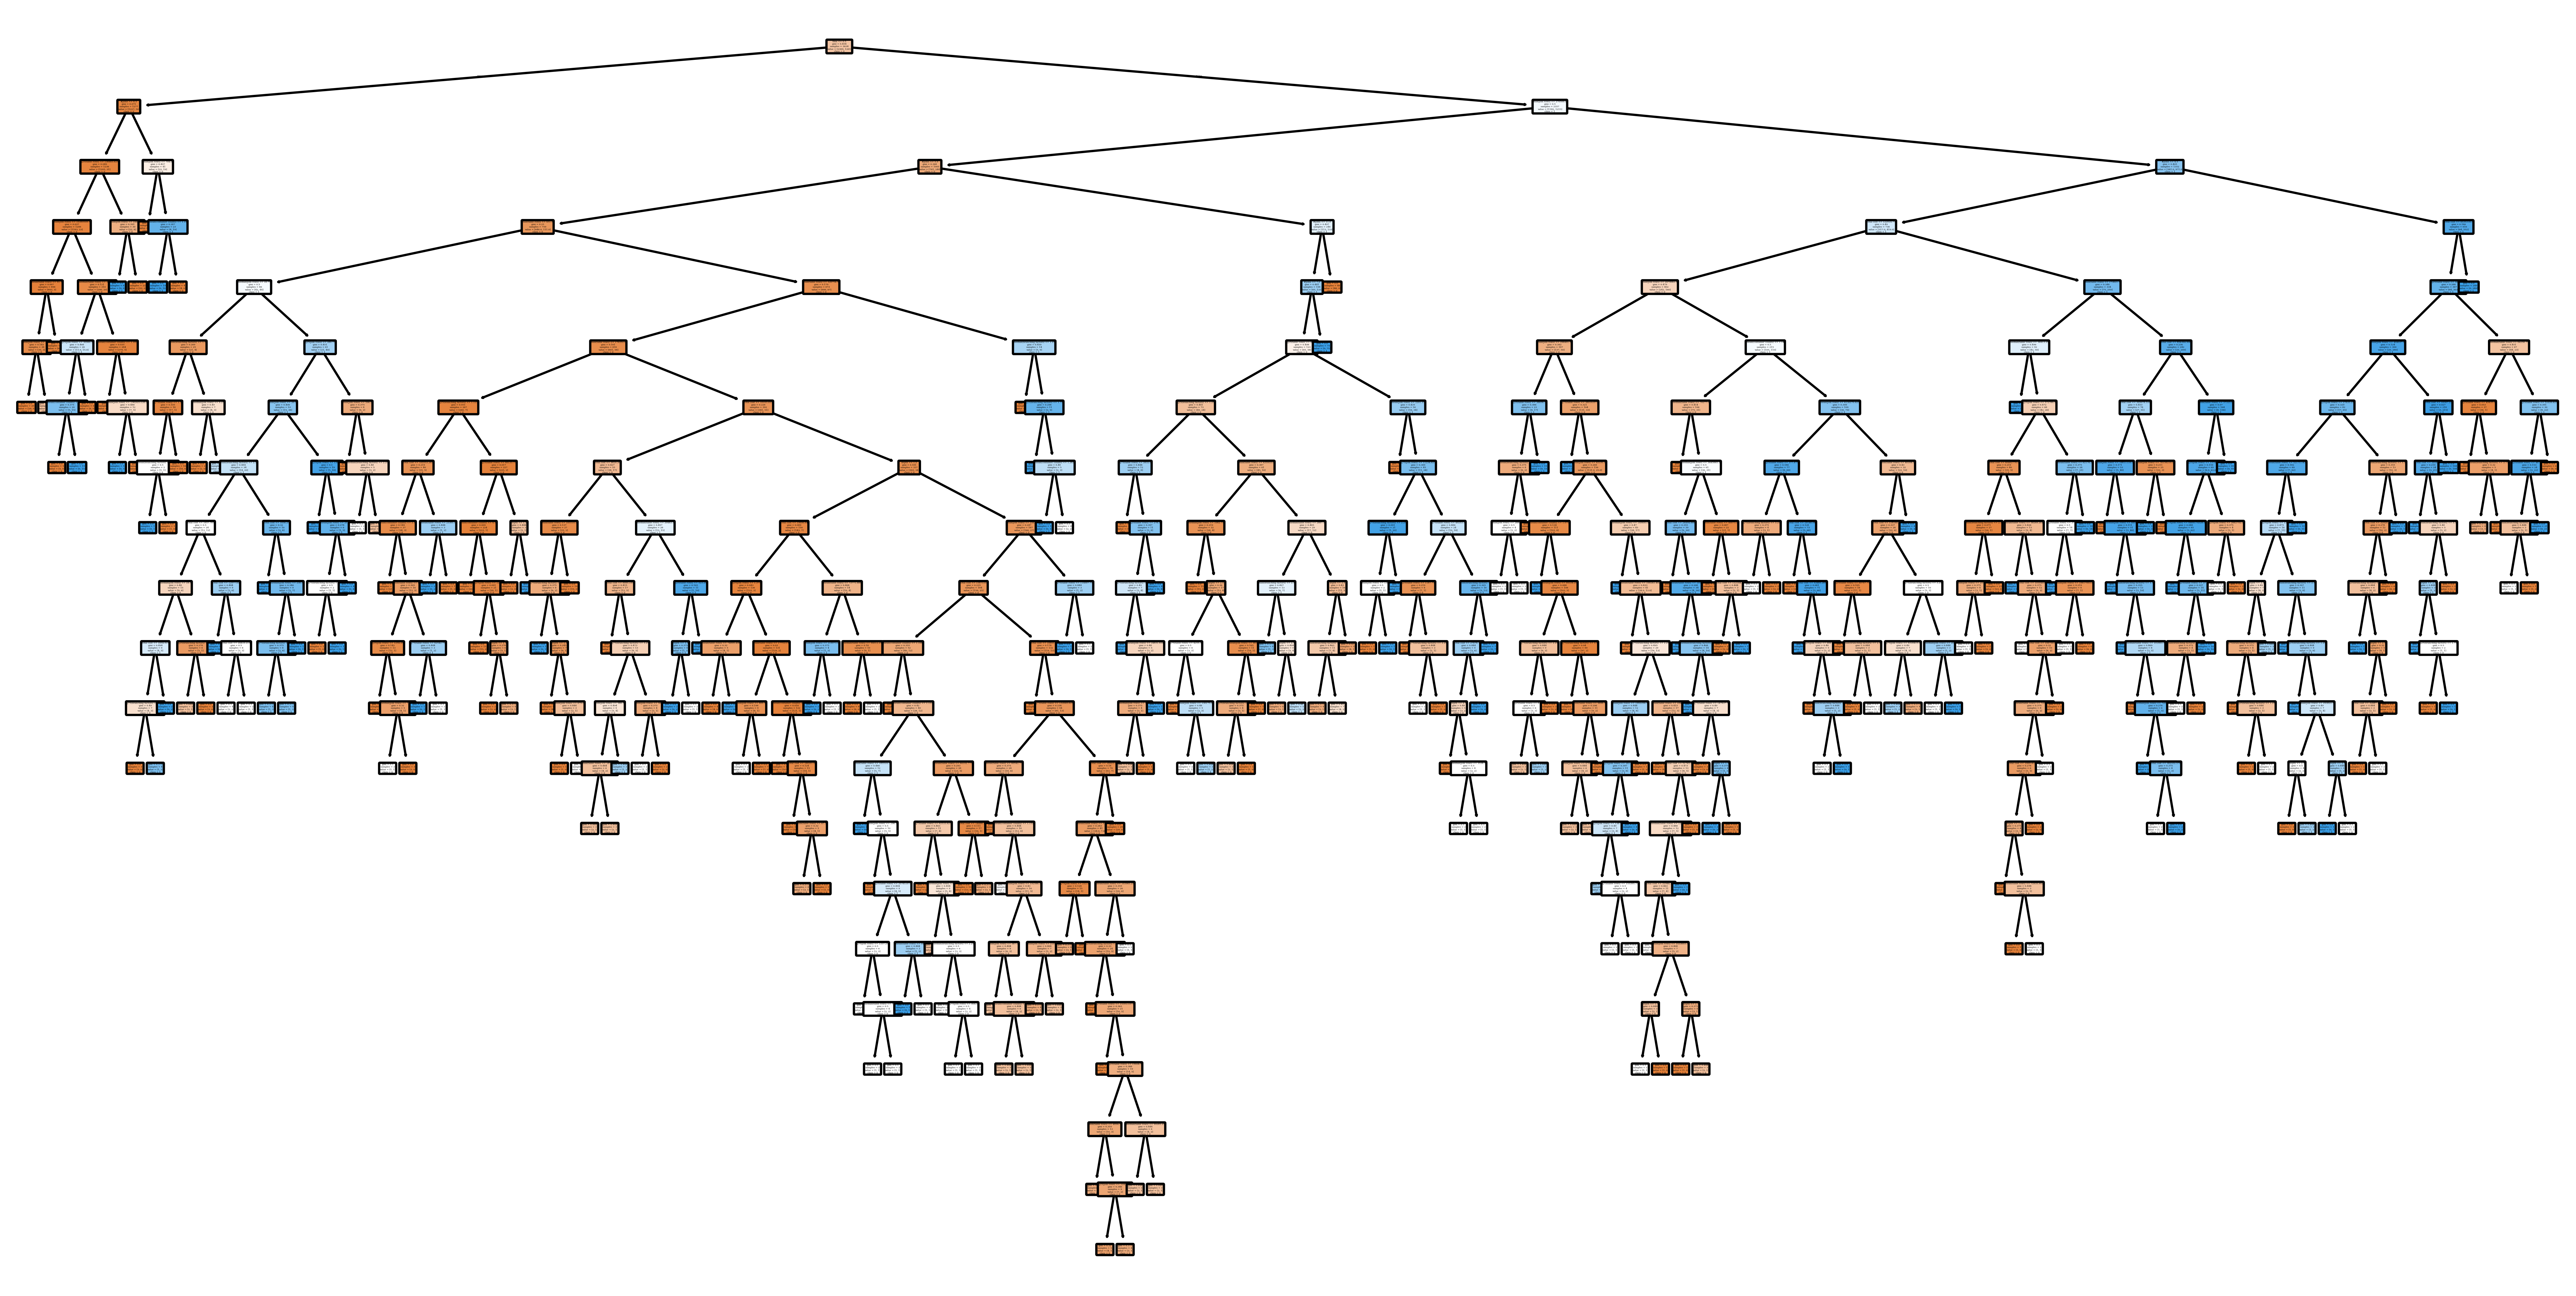

In [415]:
plt.figure(figsize=(20,10))  # Customize the size as needed
plot_tree(clf, filled=True, feature_names=X_train.columns, class_names=["0","1"], rounded=True)
plt.savefig('plots/SPA_extra_all_dec_tree_vis.png')
plt.show()

#### Plots of the runtime distributions

Plots of the distribution of the orders of magnitude for the final model on the test set in comparison to the original and rewritten plots

/tmp/ipykernel_39050/3149220611.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_orig = test_set.groupby(['interval orig', 'bench']).size().unstack(fill_value=0)
/tmp/ipykernel_39050/3149220611.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_rewr = test_set.groupby(['interval rewr', 'bench']).size().unstack(fill_value=0)
/tmp/ipykernel_39050/3149220611.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this wa

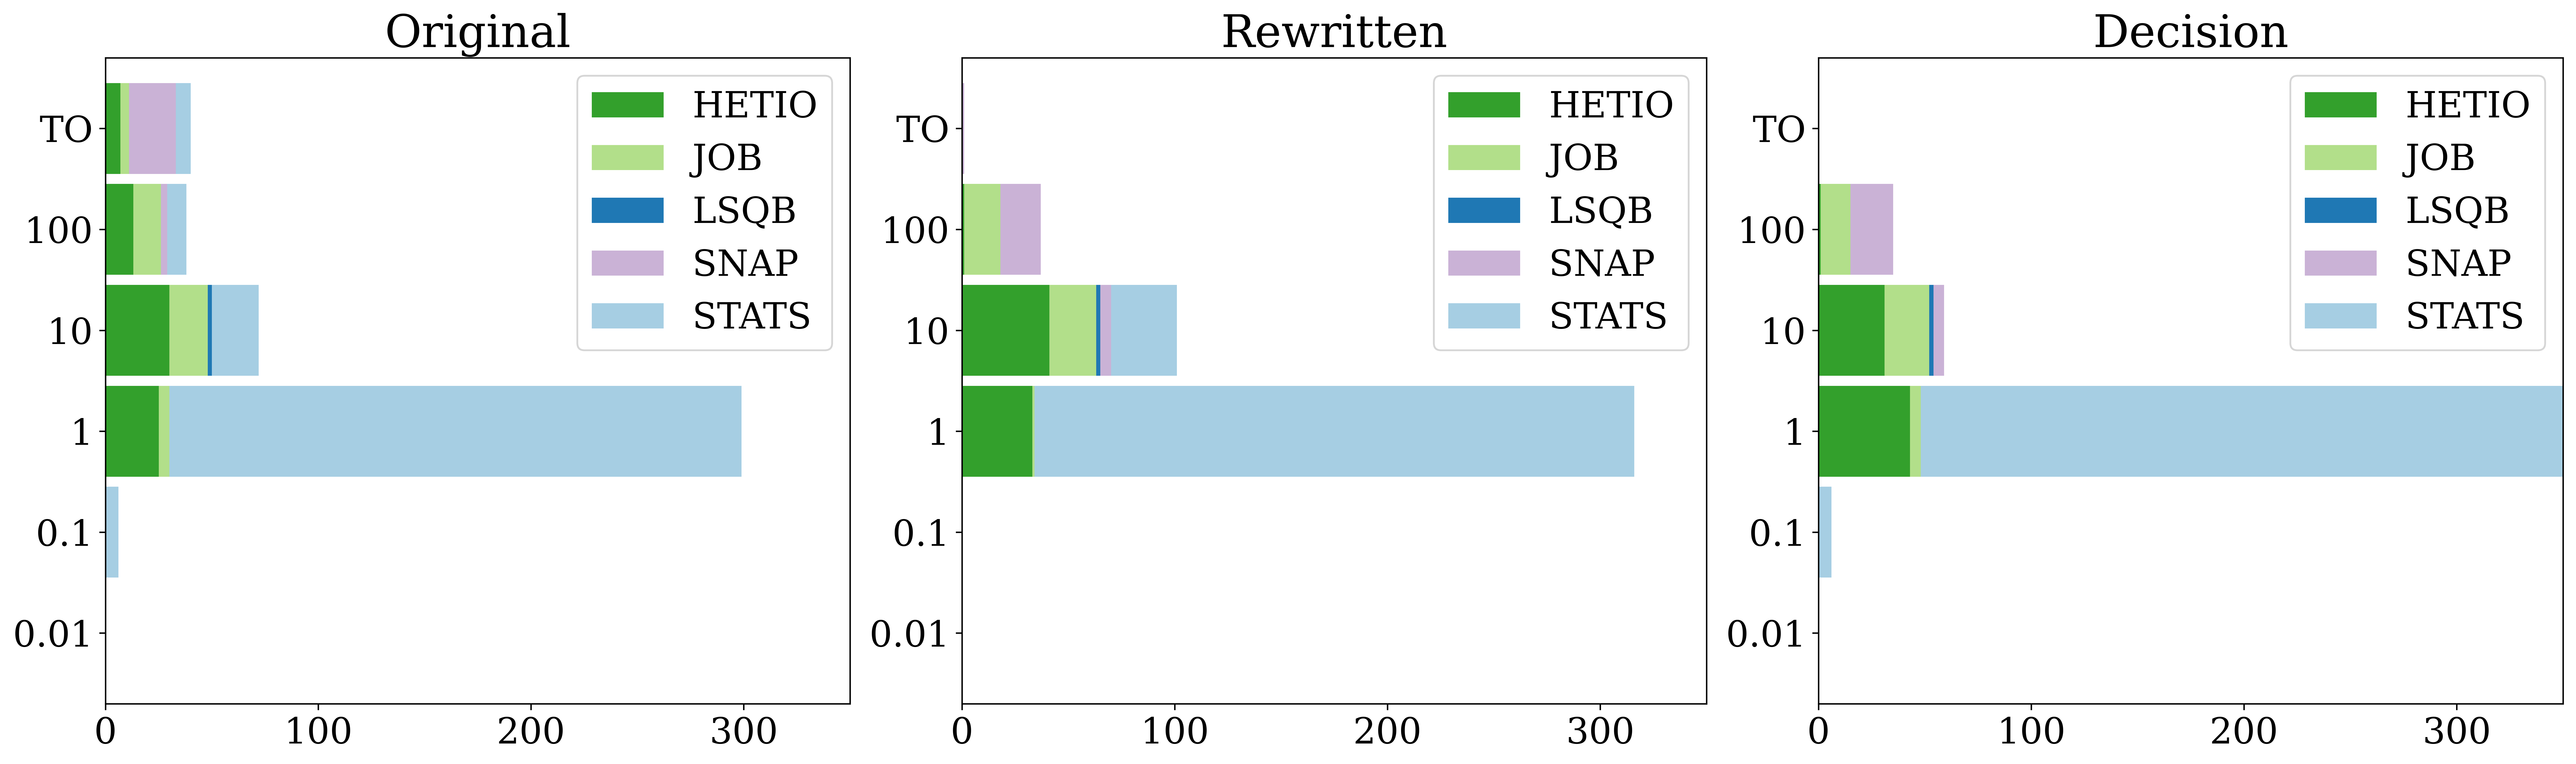

In [416]:
test_set["orig(med)"] = test_set['orig(med)'].astype("float64")
test_set["rewr(med)"] = test_set['rewr(med)'].astype("float64")
test_set["pred(med)"] = test_set['pred(med)'].astype("float64")
bins = [0, 0.01, 0.1, 1, 10, 99.99, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']
test_set['interval orig'] = pd.cut(test_set['orig(med)'], bins=bins, labels=labels)
test_set['interval rewr'] = pd.cut(test_set['rewr(med)'], bins=bins, labels=labels)
test_set['interval pred'] = pd.cut(test_set['pred(med)'], bins=bins, labels=labels)

grouped_orig = test_set.groupby(['interval orig', 'bench']).size().unstack(fill_value=0)
grouped_rewr = test_set.groupby(['interval rewr', 'bench']).size().unstack(fill_value=0)
grouped_pred = test_set.groupby(['interval pred', 'bench']).size().unstack(fill_value=0)

paired_colors = [
    '#a6cee3', '#1f78b4', '#b2df8a', '#33a02c',
    '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00',
    '#cab2d6', '#6a3d9a', '#ffff99', '#b15928'
]

category_colors = {
    'HETIO': paired_colors[3],
    'JOB': paired_colors[2],
    'LSQB': paired_colors[1],
    'SNAP': paired_colors[8],
    'STATS': paired_colors[0]
}

colors = [category_colors[col] for col in grouped_orig.columns]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

fontsize = 20
titlesize = 25
xlim = 350

# Plot for 'orig mean'
grouped_orig.plot(kind='barh', stacked=True, color=colors, ax=ax1, width = 0.9)
ax1.set_xlim(0,xlim)
#ax1.set_xlabel('Count', fontsize=fontsize)  # Increase font size for x-axis label
#ax1.set_ylabel('Order of magnitude', fontsize=fontsize)  # Increase font size for y-axis label
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_title('Original', fontsize=titlesize)  # Increase font size for title
ax1.legend(fontsize=fontsize)  # Increase font size for legend
ax1.tick_params(axis='both', which='major', labelsize=fontsize)

# Plot for 'rewr mean'
grouped_rewr.plot(kind='barh', stacked=True, color=colors, ax=ax2, width = 0.9)
#ax2.set_xlabel('Count', fontsize=fontsize)
#ax2.set_ylabel('Order of magnitude', fontsize=fontsize)
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('Rewritten', fontsize=titlesize)
ax2.legend(fontsize=fontsize)  
ax2.set_xlim(0,xlim)
ax2.tick_params(axis='both', which='major', labelsize=fontsize)

# Plot for 'pred mean'
grouped_pred.plot(kind='barh', stacked=True, color=colors, ax=ax3, width = 0.9)
#ax3.set_xlabel('Count', fontsize=fontsize)
#ax3.set_ylabel('Order of magnitude', fontsize=fontsize)
ax3.set_xlabel('')
ax3.set_ylabel('')
ax3.set_title('Decision', fontsize=titlesize)
ax3.legend(fontsize=fontsize)  
ax3.set_xlim(0,xlim)
ax3.tick_params(axis='both', which='major', labelsize=fontsize)

plt.tight_layout()
plt.savefig('plots/SPA_extra_all_runtimes_color_big.png')
plt.show()

/tmp/ipykernel_39050/1318828689.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_orig = test_set.groupby(['interval orig', 'bench']).size().unstack(fill_value=0)
/tmp/ipykernel_39050/1318828689.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_rewr = test_set.groupby(['interval rewr', 'bench']).size().unstack(fill_value=0)
/tmp/ipykernel_39050/1318828689.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this wa

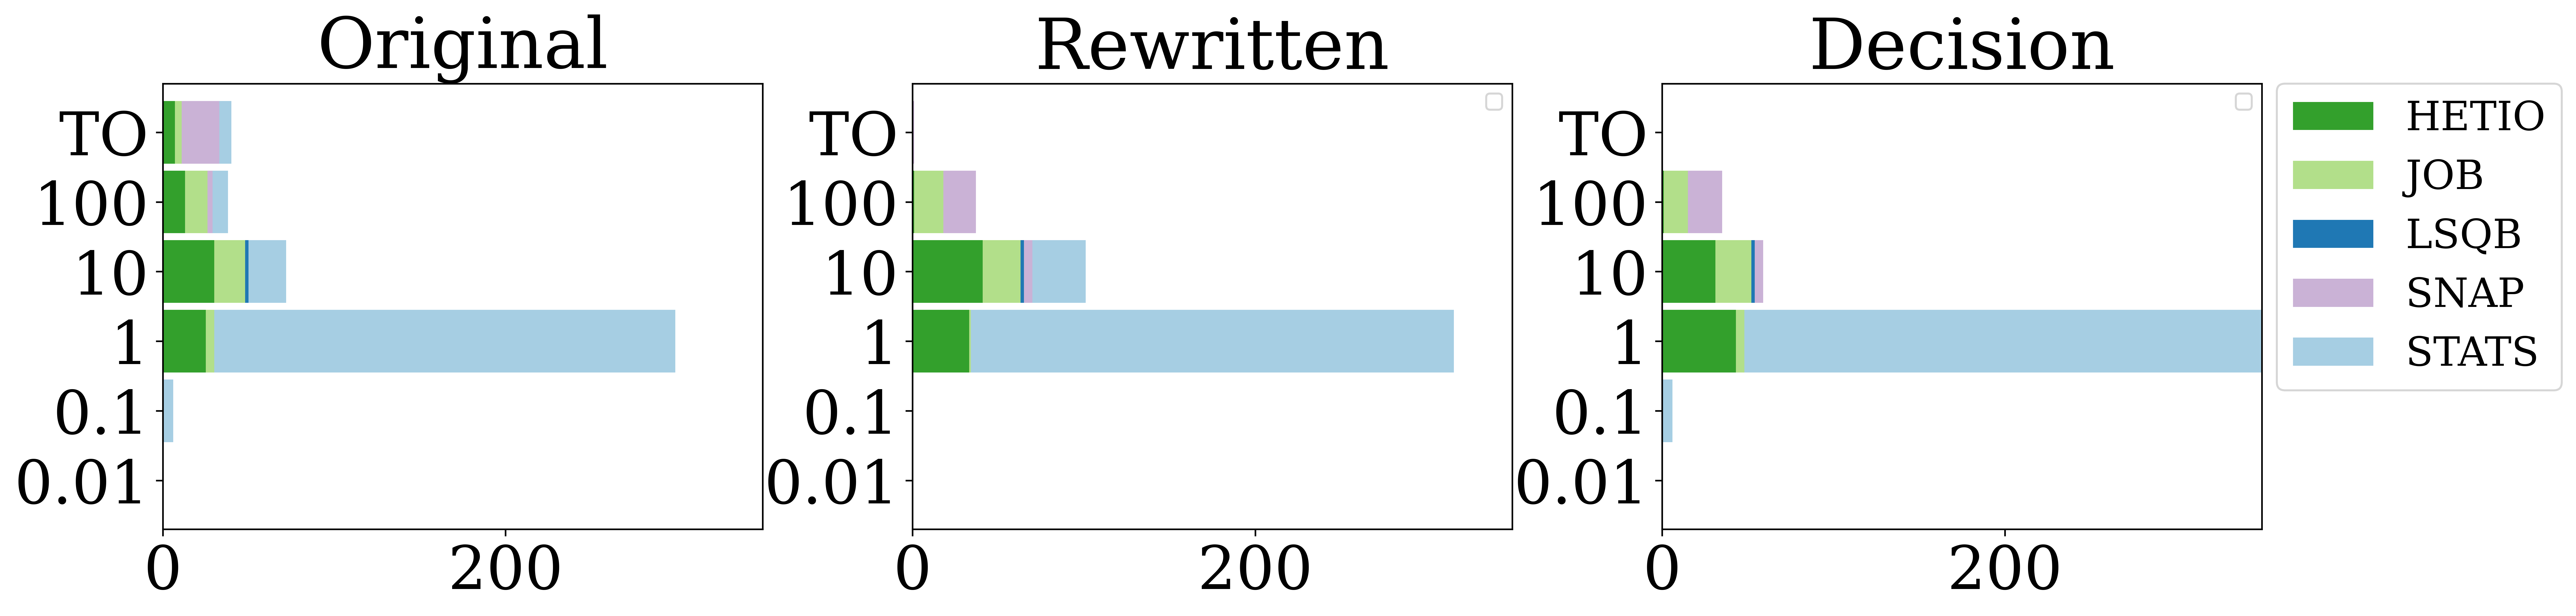

In [417]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming test_set is already defined and populated
test_set["orig(med)"] = test_set['orig(med)'].astype("float64")
test_set["rewr(med)"] = test_set['rewr(med)'].astype("float64")
test_set["pred(med)"] = test_set['pred(med)'].astype("float64")

bins = [0, 0.01, 0.1, 1, 10, 99.99, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']
test_set['interval orig'] = pd.cut(test_set['orig(med)'], bins=bins, labels=labels)
test_set['interval rewr'] = pd.cut(test_set['rewr(med)'], bins=bins, labels=labels)
test_set['interval pred'] = pd.cut(test_set['pred(med)'], bins=bins, labels=labels)

grouped_orig = test_set.groupby(['interval orig', 'bench']).size().unstack(fill_value=0)
grouped_rewr = test_set.groupby(['interval rewr', 'bench']).size().unstack(fill_value=0)
grouped_pred = test_set.groupby(['interval pred', 'bench']).size().unstack(fill_value=0)

paired_colors = [
    '#a6cee3', '#1f78b4', '#b2df8a', '#33a02c',
    '#fb9a99', '#e31a1c', '#fdbf6f', '#ff7f00',
    '#cab2d6', '#6a3d9a', '#ffff99', '#b15928'
]

category_colors = {
    'HETIO': paired_colors[3],
    'JOB': paired_colors[2],
    'LSQB': paired_colors[1],
    'SNAP': paired_colors[8],
    'STATS': paired_colors[0]
}

colors = [category_colors[col] for col in grouped_orig.columns]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))

fontsize = 30
titlesize = 35
xlim = 350

# Plot for 'orig mean'
grouped_orig.plot(kind='barh', stacked=True, color=colors, ax=ax1, width = 0.9)
ax1.set_xlim(0, xlim)
#ax1.set_xlabel('Count', fontsize=fontsize)  # Increase font size for x-axis label
#ax1.set_ylabel('Order of magnitude', fontsize=fontsize)  # Increase font size for y-axis label
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_title('Original', fontsize=titlesize)
#ax1.legend(title='Benchmark', fontsize=fontsize)  # Removed individual legend for this subplot
ax1.tick_params(axis='both', which='major', labelsize=fontsize)

# Plot for 'rewr mean'
grouped_rewr.plot(kind='barh', stacked=True, color=colors, ax=ax2, width = 0.9)
ax2.set_xlabel('')
ax2.set_ylabel('')
#ax2.set_xlabel('Count', fontsize=fontsize)
#ax2.set_ylabel('Order of magnitude', fontsize=fontsize)
ax2.set_title('Rewritten', fontsize=titlesize)
#ax2.legend(title='Benchmark', fontsize=fontsize)  # Removed individual legend for this subplot
ax2.legend('')
ax2.set_xlim(0, xlim)
ax2.tick_params(axis='both', which='major', labelsize=fontsize)

# Plot for 'pred mean'
grouped_pred.plot(kind='barh', stacked=True, color=colors, ax=ax3, width = 0.9)
ax3.set_xlabel('')
ax3.set_ylabel('')
#ax3.set_xlabel('Count', fontsize=fontsize)
#ax3.set_ylabel('Order of magnitude', fontsize=fontsize)
ax3.set_title('Decision', fontsize=titlesize)
#ax3.legend(title='Benchmark', fontsize=fontsize)  # Removed individual legend for this subplot
ax3.legend('')
ax3.set_xlim(0, xlim)
ax3.tick_params(axis='both', which='major', labelsize=fontsize)

# Add a combined legend outside the plots
handles, labels = ax1.get_legend_handles_labels()  # Use handles from the first subplot
ax1.legend(handles, labels, fontsize=20, loc='upper right', bbox_to_anchor=(4, 1), borderaxespad=0.)

# Adjust layout to make room for the legend
#plt.tight_layout()
plt.subplots_adjust(wspace = 0.25, right=0.85)  # Adjust this value to make room for the legend

plt.savefig('plots/SPA_extra_all_runtimes_color.png') 
plt.show()


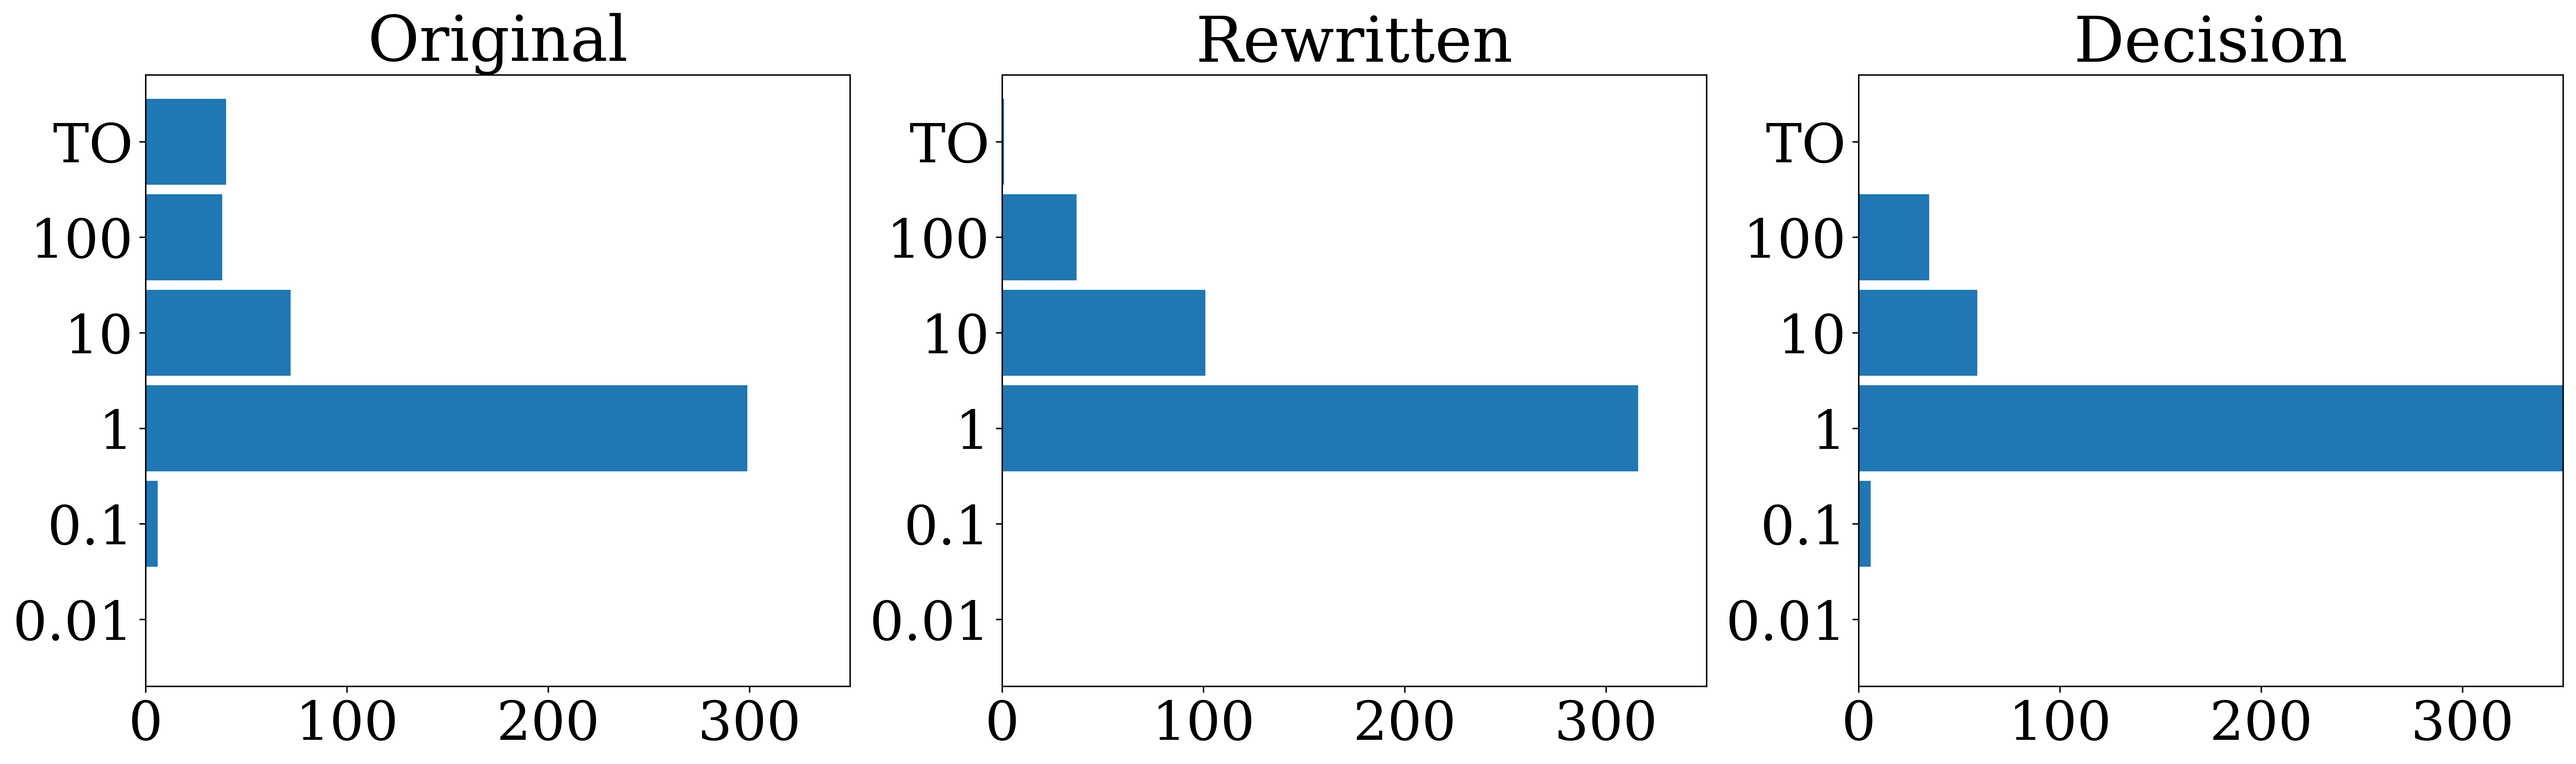

In [418]:
test_set["orig(med)"] = test_set['orig(med)'].astype("float64")
test_set["rewr(med)"] = test_set['rewr(med)'].astype("float64")
test_set["pred(med)"] = test_set['pred(med)'].astype("float64")
bins = [0, 0.01, 0.1, 1, 10, 99.99, float('inf')]
labels = ['0.01', '0.1', '1', '10', '100', 'TO']
test_set['interval orig'] = pd.cut(test_set['orig(med)'], bins=bins, labels=labels)
test_set['interval rewr'] = pd.cut(test_set['rewr(med)'], bins=bins, labels=labels)
test_set['interval pred'] = pd.cut(test_set['pred(med)'], bins=bins, labels=labels)

grouped_orig = test_set['interval orig'].value_counts().sort_index()
grouped_rewr = test_set['interval rewr'].value_counts().sort_index()
grouped_pred = test_set['interval pred'].value_counts().sort_index()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

fontsize = 30
titlesize = 35
xlim = 350

# Plot for 'orig mean'
grouped_orig.plot(kind='barh', stacked=True, ax=ax1, width = 0.9)
ax1.set_xlim(0,xlim)
#ax1.set_xlabel('Count', fontsize=fontsize)  # Increase font size for x-axis label
#ax1.set_ylabel('Order of magnitude', fontsize=fontsize)  # Increase font size for y-axis label
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.set_title('Original', fontsize=titlesize)  # Increase font size for title
ax1.tick_params(axis='both', which='major', labelsize=fontsize)

# Plot for 'rewr mean'
grouped_rewr.plot(kind='barh', stacked=True, ax=ax2, width = 0.9)
#ax2.set_xlabel('Count', fontsize=fontsize)
#ax2.set_ylabel('Order of magnitude', fontsize=fontsize)
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.set_title('Rewritten', fontsize=titlesize)
ax2.set_xlim(0,xlim)
ax2.tick_params(axis='both', which='major', labelsize=fontsize)

# Plot for 'pred mean'
grouped_pred.plot(kind='barh', stacked=True, ax=ax3, width = 0.9)
#ax3.set_xlabel('Count', fontsize=fontsize)
#ax3.set_ylabel('Order of magnitude', fontsize=fontsize)
ax3.set_xlabel('')
ax3.set_ylabel('')
ax3.set_title('Decision', fontsize=titlesize)
ax3.set_xlim(0,xlim)
ax3.tick_params(axis='both', which='major', labelsize=fontsize)

plt.tight_layout()
plt.savefig('plots/SPA_extra_all_runtimes.png')
plt.show()